<a href="https://www.kaggle.com/code/mmellinger66/s3e10-pulsar-models?scriptVersionId=122691601" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

 <div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Playground Season 3: Episode 10 - Pulsar Models</h1>
</div>

## Problem Type

Binary Classification

## Evaluation Metric

LogLoss

$$
LogLoss = \frac{1}{n} \sum_{i=1}^n [y_i log(\hat{y}_i) + (1 - y_i)log(1-\hat{y}_i)]
$$
```python
```

<div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Import Libraries</h1>
</div>

In [1]:
from typing import List, Set, Dict, Tuple, Optional

import os
import time
from pathlib import Path
import glob
import gc

import pandas as pd
import numpy as np

from sklearn import cluster
from sklearn import datasets
from sklearn import decomposition
from sklearn import ensemble
from sklearn import impute
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import svm


import xgboost as xgb
import catboost as cb
import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Visualization Libraries
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
import missingno as msno
from folium import Map
from folium.plugins import HeatMap
from IPython.display import display_html, display_markdown, display_latex
from colorama import Fore, Style

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_rows", 999)
pd.set_option("display.precision", 5)

<div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Configuration</h1>
</div>

In [2]:
TARGET="Class"
ID="id"

# Optuna
objective_direction = "minimize" # log_loss , auc , minimize, maximize

In [3]:
class Config:
    ensemble_models:bool = True
    optimize:bool = True
    N_ESTIMATORS:int = 500  # 100, 300, 1000, 2000, 5000, 15_000, 20_000 GBDT

    path:str = "../input/playground-series-s3e10/"
    load_original_data:bool = False # Some Competitions use synthetic data, based on real data
    original_data_path:str = "../input/pulsar-classification-for-class-prediction/Pulsar.csv"

    gpu:bool = False
    n_optuna_trials:int = 50 # 5, 10, 30, 50, 100
    fast_render:bool = False
    calc_probability:bool = True
    debug:bool = False
    seed:int = 42
    GPU_N_ESTIMATORS:int = 2000 # Want models to run fast during dev
    N_FOLDS:int = 20
        

In [4]:
class clr:
    S = Style.BRIGHT + Fore.LIGHTRED_EX
    E = Style.RESET_ALL

<div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Library</h1>
</div>

In [5]:
def read_data(path: str, analyze:bool=True) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    data_dir = Path(path)

    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    submission_df = pd.read_csv(data_dir / "sample_submission.csv")

    if analyze:
        print(clr.S + "=== Shape of Data ==="+clr.E)
        print(f" train data: Rows={train.shape[0]}, Columns={train.shape[1]}")
        print(f" test data : Rows={test.shape[0]}, Columns={test.shape[1]}")

        print(clr.S + "\n=== Train Data: First 5 Rows ===\n"+clr.E)
        display(train.head())
        print(f"\n{clr.S}=== Train Column Names ==={clr.E}\n")
        display(train.columns)
        print(f"\n{clr.S}=== Features/Explanatory Variables ==={clr.E}\n")
        eval_features(train)
        print(f"\n{clr.S}=== Skewness ==={clr.E}\n")
        check_skew(train)
    return train, test, submission_df

def create_submission(model_name: str, target, preds, seed:int=42, nfolds:int=5) -> pd.DataFrame:
    sample_submission[target] = preds #.astype(int)

    if len(model_name) > 0:
        fname = f"submission_{model_name}_k{nfolds}_s{seed}.csv"
    else:
        fname = "submission.csv"

    sample_submission.to_csv(fname, index=False)

    return sample_submission

def show_classification_scores(ground_truth:List[int], yhat:List[int]) -> None:
    accuracy = metrics.accuracy_score(ground_truth, yhat)
    precision = metrics.precision_score(ground_truth, yhat)
    recall = metrics.recall_score(ground_truth, yhat)
    roc = metrics.roc_auc_score(ground_truth, yhat)
    f1 = metrics.f1_score(ground_truth, yhat)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"ROC: {roc:.4f}")
    print(f"f1: {f1:.4f}")
    

def label_encoder(train:pd.DataFrame, test:pd.DataFrame, columns:List[str]) -> (pd.DataFrame, pd.DataFrame) :
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = preprocessing.LabelEncoder().fit_transform(train[col])
        test[col] = preprocessing.LabelEncoder().fit_transform(test[col])
    return train, test   

def create_strat_folds(df:pd.DataFrame, TARGET, n_folds:int=5, seed:int=42) -> pd.DataFrame:
    print(f"TARGET={TARGET}, n_folds={n_folds}, seed={seed}")
    df["fold"] = -1

    kf = model_selection.StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    # kf = GroupKFold(n_splits=Config.N_FOLDS)
    for fold, (train_idx, valid_idx) in enumerate(kf.split(df, df[TARGET])):
        df.loc[valid_idx, "fold"] = fold

    # df.to_csv(f"train_fold{num_folds}.csv", index=False)
    return df


def create_folds(df:pd.DataFrame, n_folds:int=5, seed:int=42) -> pd.DataFrame:
    print(f"n_folds={n_folds}, seed={seed}")
    df["fold"] = -1

    kf = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=seed)

    for fold, (train_idx, valid_idx) in enumerate(kf.split(df)):
        df.loc[valid_idx, "fold"] = fold

    # df.to_csv(f"train_fold{num_folds}.csv", index=False)
    return df

def show_fold_scores(scores: List[float]) -> (float, float):
    cv_score = np.mean(scores)  # Used in filename
    std_dev = np.std(scores)
    print(
        f"Scores -> Adjusted: {np.mean(scores) - np.std(scores):.8f} , mean: {np.mean(scores):.8f}, std: {np.std(scores):.8f}"
    )
    return cv_score, std_dev


def feature_distribution_types(df:pd.DataFrame, display:bool=True) -> (List[str], List[str]):
    continuous_features = list(df.select_dtypes(include=['int64', 'float64', 'uint8']).columns)
    categorical_features = list(df.select_dtypes(include=['object', 'bool']).columns)
    if display:
        print(f"{clr.S}Continuous Features={continuous_features}{clr.E}\n")
        print(f"{clr.S}Categorical Features={categorical_features}{clr.E}")
    return continuous_features, categorical_features   

def show_cardinality(df:pd.DataFrame, features:List[str]) -> None:
    print("=== Cardinality ===")
    print(df[features].nunique())

## === Model Support ===    

from scipy.stats import mode


def merge_test_predictions(final_test_predictions:List[float], calc_probability:bool=True) -> List[float]:

    if calc_probability:
        print("Mean")
        result = np.mean(np.column_stack(final_test_predictions), axis=1)
    else:
        print("Mode")
        mode_result = mode(np.column_stack(final_test_predictions), axis=1)
        result = mode_result[0].ravel()

    return result

def summary_statistics(X:pd.DataFrame, enhanced=True) -> None:
    desc = X.describe()
    if enhanced:
        desc.loc["var"] = X.var(numeric_only=True).tolist()
        desc.loc["skew"] = X.skew(numeric_only=True).tolist()
        desc.loc["kurt"] = X.kurtosis(numeric_only=True).tolist()

    with pd.option_context("display.precision", 2):
        style = desc.transpose().style.background_gradient(
            cmap="coolwarm"
        )  # .set_precision(4)
    display(style)
    
def show_missing_features(df:pd.DataFrame) -> None:
    missing_vals = df.isna().sum().sort_values(ascending=False)
    print(missing_vals[missing_vals > 0])


def show_duplicate_records(df:pd.DataFrame) -> None:
    dups = df.duplicated()
    print(dups.sum())


def eval_features(df:pd.DataFrame) -> (List[str], List[str], List[str]):
    ## Separate Categorical and Numerical Features
    categorical_features = list(
        df.select_dtypes(include=["category", "object"]).columns
    )
    continuous_features = list(df.select_dtypes(include=["number"]).columns)

    print(f"{clr.S}Continuous features:{clr.E} {continuous_features}")
    print(f"{clr.S}Categorical features:{clr.E} {categorical_features}")
    print("\n --- Cardinality of Categorical Features ---\n")

    for feature in categorical_features:
        cardinality = df[feature].nunique()
        if cardinality < 10:
            print(f"{clr.S}{feature}{clr.E}: cardinality={cardinality}, {df[feature].unique()}")
        else:
            print(f"{clr.S}{feature}{clr.E}: cardinality={cardinality}")
    all_features = categorical_features + continuous_features
    return all_features, categorical_features, continuous_features


def show_feature_importance(feature_importance_lst:List[str]) -> None:
    fis_df = pd.concat(feature_importance_lst, axis=1)

    fis_df.sort_values("0_importance", ascending=True).head(40).plot(
        kind="barh", figsize=(12, 12), title="Feature Importance Across Folds"
    )
    plt.show()


def show_feature_target_crosstab(df:pd.DataFrame, feature_lst:List[str], target:str) -> None:
    for feature in feature_lst:
        print(f"\n=== {feature} vs {target} ===\n")
        display(
            pd.crosstab(df[feature], df[target], margins=True)
        )  # display keeps bold formatting


def show_cardinality(df:pd.DataFrame, features:List[str]) -> None:
    print(f"{clr.S}=== Cardinality ==={clr.E}")
    print(df[features].nunique())


def show_unique_features(df:pd.DataFrame, features:List[str]) -> None:
    for col in features:
        print(col, sorted(df[col].dropna().unique()))


def feature_distribution_types(df:pd.DataFrame, display:bool=True) -> (List[str], List[str]):
    continuous_features = list(
        df.select_dtypes(include=["int64", "float64", "uint8"]).columns
    )
    categorical_features = list(df.select_dtypes(include=["object", "bool"]).columns)
    if display:
        print(f"{clr.S}Continuous Features={clr.E}{continuous_features}\n")
        print(f"{clr.S}Categorical Features={clr.E}{categorical_features}")
    return continuous_features, categorical_features


def describe(X:pd.DataFrame) -> None:
    """Deprecated: Use summary_statistics()"""
    desc = X.describe()
    desc.loc['var'] = X.var(numeric_only=True).tolist()
    desc.loc['skew'] = X.skew(numeric_only=True).tolist()
    desc.loc['kurt'] = X.kurtosis(numeric_only=True).tolist()

    with pd.option_context('display.precision', 2):
        style = desc.transpose().style.background_gradient(cmap='coolwarm') #.set_precision(4)
    display(style)
  

def check_skew(df:pd.DataFrame) -> None:
    skew = df.skew(skipna=True,numeric_only=True).sort_values(ascending=False)
    print(skew)
    
def gpu_ify_lgbm(lgbm_dict):
    if Config.gpu:
        lgbm_dict["device"] = "gpu"
        lgbm_dict["boosting_type"] = "gbdt"
        lgbm_dict["gpu_platform_id"] = 0
        lgbm_dict["gpu_device_id"] = 0
    return lgbm_dict

def gpu_ify_cb(params):
    if Config.gpu:
        params["task_type"] = "GPU"
    return params    


<div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Optuna Hyperparameter Optimization Library</h1>
</div>

In [6]:
def objective_xgb(trial, X_train, X_valid, y_train, y_valid):

    xgb_params = {
        #         "objective": trial.suggest_categorical("objective", ["multi:softmax"]),
        #         "eval_metric": "mlogloss",
        #         "objective": "multi:softmax",
#         "objective": trial.suggest_categorical("objective", ["mae", "rmse"]),

        "eval_metric": "rmse",  # auc, rmse, mae, logloss
        "objective": "reg:squarederror", # Normal Distribution
#         "objective": "reg:gamma", # Gamma Distribution

        #         "enable_categorical": trial.suggest_categorical("use_label_encoder", [True]),
        "use_label_encoder": trial.suggest_categorical("use_label_encoder", [False]),
        "n_estimators": trial.suggest_int("n_estimators", 1000, 5000, 100),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-2, 0.25),
        "subsample": trial.suggest_float("subsample", 0.1, 1, step=0.01),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 1, 20),  # 10
        "gamma": trial.suggest_float("gamma", 0, 100, step=0.1),
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "tree_method": trial.suggest_categorical(
            "tree_method", ["hist"]
        ),  # hist, gpu_hist
#         "predictor": "gpu_predictor",
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 100),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 100),
        "random_state": trial.suggest_categorical("random_state", [42]),
        "n_jobs": trial.suggest_categorical("n_jobs", [4]),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-1, 1e3),
        # "min_child_weight": trial.suggest_categorical("min_child_weight", [256]),
    }

    # Model loading and training
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=5000,
        verbose=0,
    )

    print(f"Number of boosting rounds: {model.best_iteration}")
    #     oof = model.predict_proba(X_valid)[:, 1] # Probability
    oof = model.predict(X_valid)  # Classification: 0,1

    return metrics.mean_squared_error(y_valid, oof, squared=False)

def objective_clf_xgb(trial, X_train, X_valid, y_train, y_valid):

    xgb_params = {
        #         "objective": trial.suggest_categorical("objective", ["multi:softmax"]),
        #         "eval_metric": "mlogloss",
        #         "objective": "multi:softmax",
        "eval_metric": "logloss",  # auc, rmse, mae, logloss
        "objective": "binary:logistic",
        #         "enable_categorical": trial.suggest_categorical("use_label_encoder", [True]),
        "use_label_encoder": trial.suggest_categorical("use_label_encoder", [False]),
        "n_estimators": trial.suggest_int("n_estimators", 1000, 5000, 100),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-2, 0.25),
        "subsample": trial.suggest_float("subsample", 0.1, 1, step=0.01),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 1, 20),  # 10
        "gamma": trial.suggest_float("gamma", 0, 100, step=0.1),
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "tree_method": trial.suggest_categorical(
            "tree_method", ["hist"]
        ),  # hist, gpu_hist
        #         "predictor": "gpu_predictor",
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 100),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 100),
        "random_state": trial.suggest_categorical("random_state", [42]),
        "n_jobs": trial.suggest_categorical("n_jobs", [4]),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-1, 1e3),
        # "min_child_weight": trial.suggest_categorical("min_child_weight", [256]),
    }

    # Model loading and training
    model = xgb.XGBClassifier(**xgb_params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=5000,
        verbose=0,
    )

    print(f"Number of boosting rounds: {model.best_iteration}")
    #     oof = model.predict_proba(X_valid)[:, 1] # Probability
    oof = model.predict(X_valid)  # Classification: 0,1
#     validation_error = metrics.roc_auc_score(y_valid, oof)
      
    validation_error = metrics.log_loss(y_valid, oof)
    
    return validation_error


def objective_lgbm(trial, X_train, X_valid, y_train, y_valid):

    lgbm_params = {
        "objective": trial.suggest_categorical("objective", ["mae", "rmse"]),
        #         "n_estimators": trial.suggest_categorical("n_estimators", [1_000]),
        #         "n_estimators": trial.suggest_categorical("n_estimators", [5000]),
        "n_estimators": trial.suggest_int("n_estimators", 700, 5000),
        "importance_type": "gain",
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1, step=0.01),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1000),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.1, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 0, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 300),
        "subsample": trial.suggest_float("subsample", 0.1, 1, step=0.01),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-2, 0.25),
        "max_depth": trial.suggest_int("max_depth", 1, 100),
        "random_state": trial.suggest_categorical("random_state", [42]),
        "n_jobs": trial.suggest_categorical("n_jobs", [4]),
        #         'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-1, 1e3),
        # "min_child_weight": trial.suggest_categorical("min_child_weight", [256]),
    }

    # Model loading and training
    model = lgb.LGBMRegressor(**lgbm_params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_metric="mae",
        callbacks=[
            lgb.log_evaluation(500),
            lgb.early_stopping(500, False, True),
        ],
    )

    #     print(f"Number of boosting rounds: {model.best_iteration}")
    oof = model.predict(X_valid)

    return metrics.mean_squared_error(y_valid, oof, squared=False)
#     return metrics.mean_absolute_error(y_valid, oof)


def objective_clf_lgbm(trial, X_train, X_valid, y_train, y_valid):

    params = {
        "boosting_type": "gbdt",
        # "objective": trial.suggest_categorical("objective", ["mae", "rmse"]),
        #         "objective": trial.suggest_categorical("objective", ["multi:softprob"]),
        #         "n_estimators": trial.suggest_categorical("n_estimators", [1_000]),
        #         "n_estimators": trial.suggest_categorical("n_estimators", [5000]),
        "n_estimators": trial.suggest_int("n_estimators", 700, 1000),
        "importance_type": "gain",
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1, step=0.01),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1000),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.1, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 0, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 300),
        "subsample": trial.suggest_float("subsample", 0.1, 1, step=0.01),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-2, 0.25),
        "max_depth": trial.suggest_int("max_depth", 1, 100),
        "random_state": trial.suggest_categorical("random_state", [42]),
        "n_jobs": trial.suggest_categorical("n_jobs", [4]),
        #         'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-1, 1e3),
        # "min_child_weight": trial.suggest_categorical("min_child_weight", [256]),
    }
    if Config.gpu:
        params["device_type"] = "gpu"

    # Model loading and training
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        # eval_metric="mae",
        callbacks=[
            lgb.log_evaluation(500),
            lgb.early_stopping(500, False, True),
        ],
    )

    #     print(f"Number of boosting rounds: {model.best_iteration}")
    oof = model.predict(X_valid)

    #     return accuracy_score(y_valid, oof)
    return metrics.roc_auc_score(y_valid, oof)


def objective_cb(trial, X_train, X_valid, y_train, y_valid):

    cb_params = {
        "iterations": 100,
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.1, 1.0),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1, 100),
        "bagging_temperature": trial.suggest_loguniform(
            "bagging_temperature", 0.1, 20.0
        ),
        "random_strength": trial.suggest_float("random_strength", 1.0, 2.0),
        "depth": trial.suggest_int("depth", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 300),
          "use_best_model": True,
#         "task_type": "GPU",
        "random_seed": 42,
    }

    # Model loading and training
    #  model = CatBoostClassifier(**cb_params)
    model = cb.CatBoostRegressor(**cb_params)

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        # eval_metric="accuracy",
        early_stopping_rounds=500,
        verbose=False,
    )

#     print(f"Number of boosting rounds: {model.best_iteration}")
    # oof = model.predict_proba(X_valid)[:, 1]
    oof = model.predict(X_valid)  # Classification
    return metrics.mean_squared_error(y_valid, oof, squared=False)
#     return metrics.mean_absolute_error(y_valid, oof)
# 
#     return accuracy_score(y_valid, oof)

def objective_clf_cb(trial, X_train, X_valid, y_train, y_valid):

    cb_params = {
        "iterations": 10,  # 1000
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.1, 1.0),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1, 100),
        "bagging_temperature": trial.suggest_loguniform(
            "bagging_temperature", 0.1, 20.0
        ),
        "random_strength": trial.suggest_float("random_strength", 1.0, 2.0),
        "depth": trial.suggest_int("depth", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 300),
        "use_best_model": True,
#             "task_type": "GPU",
        "random_seed": 42,
    }

    # Model loading and training
    model = cb.CatBoostClassifier(**cb_params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        # eval_metric="accuracy",
        early_stopping_rounds=500,
        verbose=False,
    )

    # print(f"Number of boosting rounds: {model.best_iteration}")
    # oof = model.predict_proba(X_valid)[:, 1]
    oof = model.predict(X_valid)  # Classification
    return metrics.roc_auc_score(y_valid, oof)

#     return metrics.accuracy_score(y_valid, oof)

<div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Load Train/Test Data and Analyze</h1>
</div>

## Load the following files

 - train.csv - Data used to build our machine learning model
 - test.csv - Data used to build our machine learning model. Does not contain the target variable
 - sample_submission.csv - A file in the proper format to submit test predictions

In [7]:
%%time
train, test, sample_submission = read_data(Config.path, analyze=True)                                

=== Shape of Data ===
 train data: Rows=117564, Columns=10
 test data : Rows=78377, Columns=9

=== Train Data: First 5 Rows ===



,id,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,0,133.17188,59.71608,0.04313,-0.70338,54.91722,70.08444,0.74980,-0.64951,0
1,1,87.09375,36.25797,0.43547,2.26606,3.41722,21.86507,7.03933,52.68625,0
2,2,112.64062,39.81839,0.37964,0.92231,2.73077,15.68969,8.19347,85.64978,0
3,3,120.67969,45.91845,-0.09849,0.01178,2.69649,20.95466,8.18387,70.33290,0
4,4,134.07031,57.72011,-0.10777,-0.57334,1.10786,11.25505,16.10775,308.75377,0



=== Train Column Names ===



Index(['id', 'Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve',
       'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve', 'Class'],
      dtype='object')


=== Features/Explanatory Variables ===

Continuous features: ['id', 'Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve', 'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve', 'Class']
Categorical features: []

 --- Cardinality of Categorical Features ---


=== Skewness ===

Skewness                4.39758
EK                      3.43500
Mean_DMSNR_Curve        3.42471
Class                   2.79694
Skewness_DMSNR_Curve    2.37403
SD_DMSNR_Curve          2.01034
id                      0.00000
EK_DMSNR_Curve         -0.04169
SD                     -0.52388
Mean_Integrated        -1.84135
dtype: float64
CPU times: user 300 ms, sys: 88.3 ms, total: 388 ms
Wall time: 712 ms


In [8]:
train.head()

,id,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,0,133.17188,59.71608,0.04313,-0.70338,54.91722,70.08444,0.74980,-0.64951,0
1,1,87.09375,36.25797,0.43547,2.26606,3.41722,21.86507,7.03933,52.68625,0
2,2,112.64062,39.81839,0.37964,0.92231,2.73077,15.68969,8.19347,85.64978,0
3,3,120.67969,45.91845,-0.09849,0.01178,2.69649,20.95466,8.18387,70.33290,0
4,4,134.07031,57.72011,-0.10777,-0.57334,1.10786,11.25505,16.10775,308.75377,0


In [9]:
def load_original_data(path:str) -> pd.DataFrame:
#     original = pd.read_csv(path, index_col=[0])
    original = pd.read_csv(path)

    original = original.reset_index()
    original['id'] = original['index'] + 100000
    original = original.drop(columns = ['index'])
    original = original.rename(columns = {'CementComponent ':'CementComponent'})
    original.set_index('id', inplace=True)
#     original = original[-original.depth.isna()]
    print(f"Shape={original.shape}")
    return original
#     original.head()

if Config.load_original_data:    
    original = load_original_data(Config.original_data_path)
    display(original.head())

In [10]:
if Config.load_original_data:
    train['is_original']    = 0
    test['is_original']     = 0
    original['is_original'] = 1
#     combined = pd.concat([train, original], ignore_index=True) #.drop_duplicates()
    combined = pd.concat([train, original])

    train = combined
#     combined.head()
    print(f"Shape={combined.shape}")

In [11]:
summary_statistics(train.drop(columns=[ID], axis=1), enhanced=True)

,count,mean,std,min,25%,50%,75%,max,var,skew,kurt
Mean_Integrated,117564.00,111.25,24.91,6.05,104.55,116.66,126.30,189.37,620.33,-1.84,3.90
SD,117564.00,46.71,6.10,24.78,43.44,47.48,50.86,93.60,37.25,-0.52,0.76
EK,117564.00,0.50,1.13,-1.73,0.05,0.19,0.40,7.88,1.27,3.43,11.75
Skewness,117564.00,1.89,6.52,-1.79,-0.19,0.09,0.69,65.39,42.45,4.40,20.58
Mean_DMSNR_Curve,117564.00,11.96,26.72,0.21,2.09,2.81,4.12,217.37,713.96,3.42,12.15
SD_DMSNR_Curve,117564.00,26.19,20.04,7.37,14.96,18.16,24.73,109.89,401.68,2.01,2.96
EK_DMSNR_Curve,117564.00,8.04,3.84,-2.60,6.74,8.44,10.00,34.54,14.75,-0.04,1.37
Skewness_DMSNR_Curve,117564.00,93.88,79.96,-1.98,49.41,83.42,122.09,1191.00,6393.94,2.37,11.35
Class,117564.00,0.09,0.29,0.00,0.00,0.00,0.00,1.00,0.08,2.80,5.82


## Outlier Detection

In [12]:
# https://www.kaggle.com/code/lyasdemir/best-algorithm-for-prediction-xgboost
    
def iqr(data:pd.DataFrame, var:str):# outliers detecion .
    q1 = np.quantile(data[var], 0.25)
    q3 = np.quantile(data[var], 0.75)
    diff = q3 - q1
    lower_t = q1 - (1.5 * diff)
    upper_t = q3 + (1.5 * diff)
    return data[(data[var] < lower_t) | (data[var] > upper_t)]

# iqr(train, "squareMeters")

In [13]:
# https://www.kaggle.com/code/sujithmandala/playground-s3-e8-ensemble-model-98-accuracy

def detect_outliers(data:pd.DataFrame) -> pd.DataFrame:
    outlier_percents = {}
    for column in data.columns:
        if data[column].dtype != object:
            q1 = np.quantile(data[column], 0.25)
            q3 = np.quantile(data[column], 0.75)
            iqr = q3 - q1
            upper_bound = q3 + (1.5 * iqr)
            lower_bound = q1 - (1.5 * iqr)
            outliers = data[(data[column] > upper_bound) | (data[column] < lower_bound)][column]
            outlier_percentage = len(outliers) / len(data[column]) * 100
            outlier_percents[column] = outlier_percentage
            outlier_dataframe = pd.DataFrame(data = outlier_percents.values() ,index=outlier_percents.keys() ,columns=['Outlier_percentage'])
    
    return outlier_dataframe.sort_values(by = 'Outlier_percentage', ascending = False)

detect_outliers(train)


,Outlier_percentage
Mean_DMSNR_Curve,17.64486
SD_DMSNR_Curve,15.87646
EK_DMSNR_Curve,13.55007
Skewness,11.22112
EK,9.40084
Class,9.32854
Mean_Integrated,7.76768
Skewness_DMSNR_Curve,4.80844
SD,3.19656
id,0.00000


In [14]:
# https://www.kaggle.com/code/sujithmandala/playground-s3-e8-ensemble-model-98-accuracy
    
def detect_outliers(data:pd.DataFrame) -> pd.DataFrame:
    outlier_percents = {}
    for column in data.columns:
        if data[column].dtype != object:
            q1 = np.quantile(data[column], 0.25)
            q3 = np.quantile(data[column], 0.75)
            iqr = q3 - q1
            upper_bound = q3 + (1.5 * iqr)
            lower_bound = q1 - (1.5 * iqr)
            outliers = data[(data[column] > upper_bound) | (data[column] < lower_bound)][column]
            outlier_percentage = len(outliers) / len(data[column]) * 100
            outlier_percents[column] = outlier_percentage
            outlier_dataframe = pd.DataFrame(data = outlier_percents.values() ,index=outlier_percents.keys() ,columns=['Outlier_percentage'])
    
    return outlier_dataframe.sort_values(by = 'Outlier_percentage', ascending = False)

detect_outliers(test)


,Outlier_percentage
Mean_DMSNR_Curve,17.51662
SD_DMSNR_Curve,15.72655
EK_DMSNR_Curve,13.73234
Skewness,11.11168
EK,9.19275
Mean_Integrated,7.62979
Skewness_DMSNR_Curve,4.75395
SD,3.19609
id,0.00000


## Identify Outliers in this Dataset

- https://www.kaggle.com/competitions/playground-series-s3e10/discussion/393093
- https://www.kaggle.com/code/sujaykapadnis/s3e10-eda

In [15]:
def remove_pulsar_outliers(train):
    outliers = train[
        (train['Class'] == 1) &
        (train['Mean_Integrated'] > 115) &
        (train['SD'] > 45) &
        (train['EK'] < 0.03) &
        (train['Skewness'] < 1) &
        (train['Mean_DMSNR_Curve'] < 20)
    ].index
    train.drop(outliers,inplace=True)
    train.reset_index()
    return train

In [16]:
train = remove_pulsar_outliers(train)

<div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Feature Engineering</h1>
</div>

## Categorical/Numerical Variables

In [17]:
# train.drop(['cityCode'], axis=1, inplace=True)
# test.drop(['cityCode'], axis=1, inplace=True)


## Handle Outliers
- https://www.kaggle.com/code/lyasdemir/best-algorithm-for-prediction-xgboost
- https://www.kaggle.com/code/mnokno/paris-housing-price-prediction-using-xgboost

In [18]:
# features_with_outliers = ['attic', 'garage', 'made', 'basement', 'floors', 'cityCode', 'squareMeters']
# features_with_outliers = ['attic', 'garage', 'made', 'basement', 'floors',  'squareMeters']

In [19]:
# https://www.kaggle.com/code/mnokno/paris-housing-price-prediction-using-xgboost

def remove_outliers(df:pd.DataFrame) -> pd.DataFrame:
    for c in features_with_outliers:
        if c == 'garage':
            first_percentile = df[c].quantile(0.001)
            df = df[df[c] > first_percentile]

        ninety_ninth_percentile = df[c].quantile(0.999)
        df = df[df[c] < ninety_ninth_percentile]
        #df_t = df_t[(df_t[c] > first_percentile) & (df_t[c] < ninety_ninth_percentile)]
    return df


In [20]:
# print(f'Before: {len(train)}')
# train = remove_outliers(train)
# print(f'After: {len(train)}')

In [21]:
train.head(10)

,id,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,0,133.17188,59.71608,0.04313,-0.70338,54.91722,70.08444,0.74980,-0.64951,0
1,1,87.09375,36.25797,0.43547,2.26606,3.41722,21.86507,7.03933,52.68625,0
2,2,112.64062,39.81839,0.37964,0.92231,2.73077,15.68969,8.19347,85.64978,0
3,3,120.67969,45.91845,-0.09849,0.01178,2.69649,20.95466,8.18387,70.33290,0
4,4,134.07031,57.72011,-0.10777,-0.57334,1.10786,11.25505,16.10775,308.75377,0
5,5,131.63281,52.56321,-0.07525,-0.49583,2.19482,15.53743,9.03344,97.03241,0
6,6,110.93750,41.55695,0.31284,0.55902,1.96572,17.19147,10.39677,118.72427,0
7,7,120.20312,49.92790,-0.08999,-0.32137,3.28010,18.37684,8.19056,77.91724,0
8,8,112.41406,46.93987,0.28255,0.15178,3.33696,21.92953,7.69333,65.18628,0
9,9,99.85938,48.08919,0.69371,0.28166,3.41472,24.18191,7.95868,65.08458,0


In [22]:
train = train.reset_index(drop=True).copy()
train.head(10)

,id,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,0,133.17188,59.71608,0.04313,-0.70338,54.91722,70.08444,0.74980,-0.64951,0
1,1,87.09375,36.25797,0.43547,2.26606,3.41722,21.86507,7.03933,52.68625,0
2,2,112.64062,39.81839,0.37964,0.92231,2.73077,15.68969,8.19347,85.64978,0
3,3,120.67969,45.91845,-0.09849,0.01178,2.69649,20.95466,8.18387,70.33290,0
4,4,134.07031,57.72011,-0.10777,-0.57334,1.10786,11.25505,16.10775,308.75377,0
5,5,131.63281,52.56321,-0.07525,-0.49583,2.19482,15.53743,9.03344,97.03241,0
6,6,110.93750,41.55695,0.31284,0.55902,1.96572,17.19147,10.39677,118.72427,0
7,7,120.20312,49.92790,-0.08999,-0.32137,3.28010,18.37684,8.19056,77.91724,0
8,8,112.41406,46.93987,0.28255,0.15178,3.33696,21.92953,7.69333,65.18628,0
9,9,99.85938,48.08919,0.69371,0.28166,3.41472,24.18191,7.95868,65.08458,0


In [23]:
excluded_features = [TARGET, ID, "fold", "is_original"]

In [24]:
cont_features, cat_features = feature_distribution_types(train, display=True)
show_cardinality(train, cat_features)

cont_features = [feature for feature in cont_features if feature not in excluded_features]
cat_features = [feature for feature in cat_features if feature not in excluded_features]

FEATURES = cont_features + cat_features
FEATURES

Continuous Features=['id', 'Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve', 'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve', 'Class']

Categorical Features=[]
=== Cardinality ===
Series([], dtype: float64)


['Mean_Integrated',
 'SD',
 'EK',
 'Skewness',
 'Mean_DMSNR_Curve',
 'SD_DMSNR_Curve',
 'EK_DMSNR_Curve',
 'Skewness_DMSNR_Curve']

In [25]:
train, test = label_encoder(train, test, cat_features)
# train = pd.get_dummies(train,columns=['cut','color','clarity']) # Will remove original feature names
# test = pd.get_dummies(test,columns=['cut','color','clarity'])

In [26]:
train.head()

,id,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,0,133.17188,59.71608,0.04313,-0.70338,54.91722,70.08444,0.74980,-0.64951,0
1,1,87.09375,36.25797,0.43547,2.26606,3.41722,21.86507,7.03933,52.68625,0
2,2,112.64062,39.81839,0.37964,0.92231,2.73077,15.68969,8.19347,85.64978,0
3,3,120.67969,45.91845,-0.09849,0.01178,2.69649,20.95466,8.18387,70.33290,0
4,4,134.07031,57.72011,-0.10777,-0.57334,1.10786,11.25505,16.10775,308.75377,0


## PCA

,pca_1,pca_2,pca_3
0,1.20180,-3.87510,1.72397
1,0.86421,0.90986,1.73093
2,-0.12628,0.61964,1.73033
3,-0.58077,-0.25392,1.72746
4,-3.16499,0.90359,1.73893
...,...,...,...
117555,-0.84787,-1.60650,-1.73941
117556,-1.35101,0.27135,-1.73161
117557,-0.53336,-0.67113,-1.73749
117558,-0.48885,0.40115,-1.73271


,id,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class,pca_1,pca_2,pca_3
0,0,133.17188,59.71608,0.04313,-0.70338,54.91722,70.08444,0.74980,-0.64951,0,1.20180,-3.87510,1.72397
1,1,87.09375,36.25797,0.43547,2.26606,3.41722,21.86507,7.03933,52.68625,0,0.86421,0.90986,1.73093
2,2,112.64062,39.81839,0.37964,0.92231,2.73077,15.68969,8.19347,85.64978,0,-0.12628,0.61964,1.73033
3,3,120.67969,45.91845,-0.09849,0.01178,2.69649,20.95466,8.18387,70.33290,0,-0.58077,-0.25392,1.72746
4,4,134.07031,57.72011,-0.10777,-0.57334,1.10786,11.25505,16.10775,308.75377,0,-3.16499,0.90359,1.73893


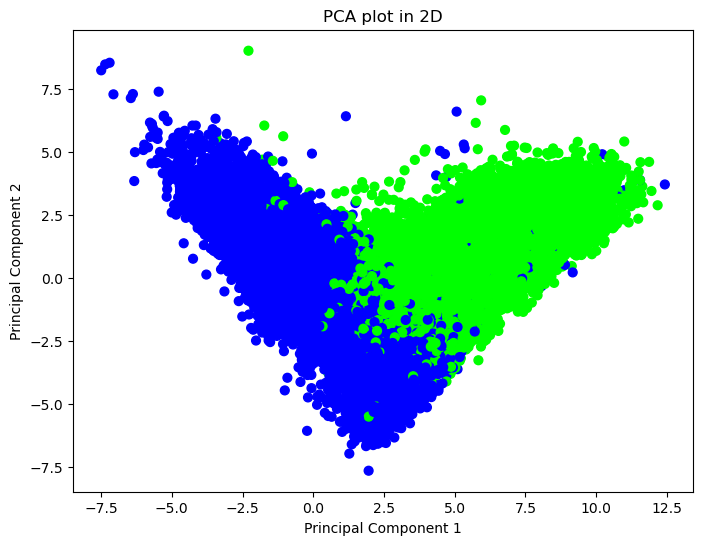

,pca_1,pca_2,pca_3
0,-1.63950,-0.63537,1.73116
1,-1.43031,0.69415,1.74267
2,-0.80932,-0.91371,1.72283
3,0.67929,-0.35832,1.72166
4,0.20621,1.56817,1.73843
...,...,...,...
78372,-1.69931,1.32091,-1.71563
78373,-1.06082,0.52522,-1.72842
78374,-1.22723,0.61773,-1.72660
78375,0.01143,1.64852,-1.72023


,id,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,pca_1,pca_2,pca_3
0,117564,140.04688,54.50780,0.05886,-0.56726,2.33779,14.86833,9.59176,117.98878,-1.63950,-0.63537,1.73116
1,117565,107.82812,51.57897,0.28437,-0.33843,1.57441,12.50144,11.69497,182.70482,-1.43031,0.69415,1.74267
2,117566,135.06250,49.81234,-0.08778,-0.09434,3.57692,21.24334,7.25239,59.02150,-0.80932,-0.91371,1.72283
3,117567,112.81250,41.92665,0.51992,1.28776,6.66973,29.01315,5.09766,27.10524,0.67929,-0.35832,1.72166
4,117568,96.21094,35.32262,0.48129,2.44308,2.21823,17.04106,9.76601,117.13178,0.20621,1.56817,1.73843


In [27]:
def plot_explained_variance(pca, X:pd.DataFrame) -> None:
    plt.figure(figsize=(14,5))
    xi = np.arange(1,1+X.shape[1], step=1)
    yi = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(xi, yi, marker='o', linestyle='--', color='b')

    # Aesthetics
    plt.ylim(0.0,1.1)
    plt.xlabel('Number of Components')
    plt.xticks(np.arange(1, 1+X.shape[1], step=2))
    plt.ylabel('Cumulative variance (%)')
    plt.title('Explained variance by each component')
    plt.axhline(y=1, color='r', linestyle='-')
    plt.gca().xaxis.grid(False)
    plt.show()

def plot_pca(pca_df:pd.DataFrame, y) -> None:
    plt.figure(figsize=(8,6))
    plt.scatter(pca_df.iloc[:,0], pca_df.iloc[:,1], c=y, cmap="brg", s=40)
#     plt.scatter(pca_df.iloc[:,0], pca_df.iloc[:,1], cmap="brg", s=40)

    plt.title('PCA plot in 2D')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

def extract_pca(df:pd.DataFrame, TARGET:str, n_pca_components:int = 3) -> pd.DataFrame:

    pca = decomposition.PCA(
        n_components=n_pca_components,
        svd_solver='full',
    )
    if len(TARGET) > 0:
        X = df.drop(columns=[TARGET])
    else:
        X = df
        
    scaler = preprocessing.StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
    pca_transform = pca.fit_transform(X)
    
    
    pca_cols = [f'pca_{i}' for i in list(range(1, n_pca_components + 1))]  
    
    pca_df = pd.DataFrame(
        data=pca_transform,
        columns=pca_cols,
    )
    display(pca_df)
    df = df.join(pca_df)
    display(df.head())
    if len(TARGET) > 0:
        y = df[TARGET]
        plot_pca(pca_df, y)
#         plot_explained_variance(pca, X)

    return df
    
train = extract_pca(train, TARGET, 3)    
test = extract_pca(test, "", 3)    

## KMeans

- https://www.kaggle.com/code/xaviernogueira/baseline-pulsars-w-catboost-xgboost

In [28]:
# make an array of weights where 0->0.1 and 1->1
def swap(v) -> pd.Series:
    if v == 0:
        return 0.1
    else: return 1
weights = train.Class.apply(swap)

In [29]:
%%time
# make 2 and 5 class Kmeans clusters
k_means_obj2 = cluster.KMeans(
    n_clusters=2,
).fit(
    train.drop(columns=[TARGET]),
    sample_weight=weights,
)
k_means_obj5 = cluster.KMeans(
    n_clusters=5,
).fit(
    train.drop(columns=[TARGET]),
    sample_weight=weights,
)

CPU times: user 13 s, sys: 2.91 s, total: 15.9 s
Wall time: 4.11 s


In [30]:
train['k2'] = k_means_obj2.predict(train.drop(columns=[TARGET]))
train['k5'] = k_means_obj5.predict(train.drop(columns=[TARGET, 'k2']))

test['k2'] = k_means_obj2.predict(test)
test['k5'] = k_means_obj5.predict(test.drop(columns=['k2']))


In [31]:
train.head()

,id,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class,pca_1,pca_2,pca_3,k2,k5
0,0,133.17188,59.71608,0.04313,-0.70338,54.91722,70.08444,0.74980,-0.64951,0,1.20180,-3.87510,1.72397,1,3
1,1,87.09375,36.25797,0.43547,2.26606,3.41722,21.86507,7.03933,52.68625,0,0.86421,0.90986,1.73093,1,3
2,2,112.64062,39.81839,0.37964,0.92231,2.73077,15.68969,8.19347,85.64978,0,-0.12628,0.61964,1.73033,1,3
3,3,120.67969,45.91845,-0.09849,0.01178,2.69649,20.95466,8.18387,70.33290,0,-0.58077,-0.25392,1.72746,1,3
4,4,134.07031,57.72011,-0.10777,-0.57334,1.10786,11.25505,16.10775,308.75377,0,-3.16499,0.90359,1.73893,1,3


In [32]:
cont_features, cat_features = feature_distribution_types(train, display=True)
show_cardinality(train, cat_features)

cont_features = [feature for feature in cont_features if feature not in excluded_features]
cat_features = [feature for feature in cat_features if feature not in excluded_features]

FEATURES = cont_features + cat_features
FEATURES

Continuous Features=['id', 'Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve', 'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve', 'Class', 'pca_1', 'pca_2', 'pca_3']

Categorical Features=[]
=== Cardinality ===
Series([], dtype: float64)


['Mean_Integrated',
 'SD',
 'EK',
 'Skewness',
 'Mean_DMSNR_Curve',
 'SD_DMSNR_Curve',
 'EK_DMSNR_Curve',
 'Skewness_DMSNR_Curve',
 'pca_1',
 'pca_2',
 'pca_3']

<div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Optuna Hyperparameter Optimization</h1>
</div>

In [33]:
%%time

study_name=objective_direction # Need better name

if Config.optimize:
    y = train[TARGET]
    X = train[FEATURES].copy()

    X_test = test[FEATURES].copy()
    X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
        X, y, test_size=0.2, random_state=Config.seed
    )

# === XGB ===

time_limit = 3600 * 3
best_xgb_params = {}

if Config.optimize:
    study = optuna.create_study(direction=objective_direction, study_name=f"xgboost {objective_direction}")
    study.optimize(
        lambda trial: objective_clf_xgb(trial, X_train, X_valid, y_train, y_valid),
#         lambda trial: objective_xgb(trial, X_train, X_valid, y_train, y_valid),        
        n_trials=Config.n_optuna_trials,
        # timeout=time_limit,  # this or n_trials
    )

if Config.optimize:
    print("Number of finished trials:", len(study.trials))
    print("Best XGB trial parameters:", study.best_trial.params)
    print("Best score:", study.best_value)
    best_xgb_params = study.best_trial.params

## === LGBM ===

time_limit = 3600 * 3
best_lgbm_params = {}

if Config.optimize:
    study = optuna.create_study(direction=objective_direction,study_name=f"LGBM {objective_direction}")
    study.optimize(
        lambda trial: objective_clf_lgbm(trial, X_train, X_valid, y_train, y_valid),
#         lambda trial: objective_lgbm(trial, X_train, X_valid, y_train, y_valid),        
        n_trials=Config.n_optuna_trials,
        # timeout=time_limit,  # this or n_trials
    )

if Config.optimize:
    print("Number of finished trials:", len(study.trials))
    print("Best LGBM trial parameters:", study.best_trial.params)
    print("Best score:", study.best_value)
    best_lgbm_params = study.best_trial.params

## === CatBoost

time_limit = 3600 * 3
# best_cb_params = {}
best_cb_params = {'learning_rate': 0.45743264601999495,
                  'l2_leaf_reg': 41.338946049390074,
                  'bagging_temperature': 0.3472567739474319,
                  'random_strength': 1.7332249677756242, 
                  'depth': 1,
                  'min_data_in_leaf': 6}

if Config.optimize:
    study = optuna.create_study(direction=objective_direction,study_name=f"CatBoost {objective_direction}")
    study.optimize(
        lambda trial: objective_clf_cb(trial, X_train, X_valid, y_train, y_valid),
#         lambda trial: objective_cb(trial, X_train, X_valid, y_train, y_valid),
        n_trials=Config.n_optuna_trials,
        # timeout=time_limit,  # this or n_trials
    )

if Config.optimize:
    print("Number of finished trials:", len(study.trials))
    print("Best Cat trial parameters:", study.best_trial.params)
    print("Best score:", study.best_value)
    best_cb_params = study.best_trial.params

[I 2023-03-19 18:49:38,041] A new study created in memory with name: xgboost minimize
[I 2023-03-19 18:50:12,933] Trial 0 finished with value: 0.3275863858395509 and parameters: {'use_label_encoder': False, 'n_estimators': 2300, 'learning_rate': 0.16347260938070435, 'subsample': 0.37, 'colsample_bytree': 0.49, 'max_depth': 17, 'gamma': 22.5, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 4.115611568789383e-08, 'reg_alpha': 9.3568257828065e-08, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 41.33203598103943}. Best is trial 0 with value: 0.3275863858395509.


Number of boosting rounds: 2299


[I 2023-03-19 18:51:08,252] Trial 1 finished with value: 0.3231791246298876 and parameters: {'use_label_encoder': False, 'n_estimators': 3600, 'learning_rate': 0.027072012393917315, 'subsample': 0.96, 'colsample_bytree': 0.31, 'max_depth': 4, 'gamma': 24.0, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 6.192808383173342, 'reg_alpha': 6.625015368698685e-07, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 7.418475433770841}. Best is trial 1 with value: 0.3231791246298876.


Number of boosting rounds: 3589


[I 2023-03-19 18:51:43,509] Trial 2 finished with value: 0.31436528237169586 and parameters: {'use_label_encoder': False, 'n_estimators': 2300, 'learning_rate': 0.02382456374255698, 'subsample': 0.36, 'colsample_bytree': 0.7500000000000001, 'max_depth': 17, 'gamma': 43.6, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 4.203586500189581e-08, 'reg_alpha': 0.008951735261149634, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.9420706140521379}. Best is trial 2 with value: 0.31436528237169586.


Number of boosting rounds: 2299


[I 2023-03-19 18:52:12,992] Trial 3 finished with value: 0.32758590972675644 and parameters: {'use_label_encoder': False, 'n_estimators': 1900, 'learning_rate': 0.012143764336504586, 'subsample': 0.58, 'colsample_bytree': 0.51, 'max_depth': 10, 'gamma': 2.7, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 0.0011112463594062595, 'reg_alpha': 0.04170256735577907, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 413.2293275565106}. Best is trial 2 with value: 0.31436528237169586.


Number of boosting rounds: 1485


[I 2023-03-19 18:52:37,010] Trial 4 finished with value: 0.3334619519337968 and parameters: {'use_label_encoder': False, 'n_estimators': 1600, 'learning_rate': 0.010618479420121648, 'subsample': 0.9, 'colsample_bytree': 0.22999999999999998, 'max_depth': 7, 'gamma': 34.4, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 2.155441090649951e-06, 'reg_alpha': 0.4251316734997571, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 185.38918205394674}. Best is trial 2 with value: 0.31436528237169586.


Number of boosting rounds: 1590


[I 2023-03-19 18:53:33,084] Trial 5 finished with value: 0.3070204251592217 and parameters: {'use_label_encoder': False, 'n_estimators': 3800, 'learning_rate': 0.03677093923996747, 'subsample': 0.18, 'colsample_bytree': 0.9600000000000001, 'max_depth': 1, 'gamma': 77.9, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 7.795569585517461, 'reg_alpha': 0.033471957077946854, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.22844378043564276}. Best is trial 5 with value: 0.3070204251592217.


Number of boosting rounds: 3698


[I 2023-03-19 18:54:37,927] Trial 6 finished with value: 0.321710275616397 and parameters: {'use_label_encoder': False, 'n_estimators': 4400, 'learning_rate': 0.11859602877259108, 'subsample': 0.8, 'colsample_bytree': 0.43, 'max_depth': 18, 'gamma': 14.8, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 0.6923589455553683, 'reg_alpha': 1.9478583827069462e-05, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 63.58695778109885}. Best is trial 5 with value: 0.3070204251592217.


Number of boosting rounds: 1836


[I 2023-03-19 18:55:35,799] Trial 7 finished with value: 0.3158343014254701 and parameters: {'use_label_encoder': False, 'n_estimators': 3800, 'learning_rate': 0.03314573407221648, 'subsample': 0.65, 'colsample_bytree': 0.79, 'max_depth': 8, 'gamma': 70.9, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 5.3434156298949236e-06, 'reg_alpha': 17.265365986787142, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 13.334350166072348}. Best is trial 5 with value: 0.3070204251592217.


Number of boosting rounds: 2929


[I 2023-03-19 18:56:44,365] Trial 8 finished with value: 0.31289629732597835 and parameters: {'use_label_encoder': False, 'n_estimators': 4600, 'learning_rate': 0.16931482234452866, 'subsample': 0.6799999999999999, 'colsample_bytree': 0.9600000000000001, 'max_depth': 17, 'gamma': 35.7, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 0.18962876478221777, 'reg_alpha': 0.6310087731260462, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.358869754061561}. Best is trial 5 with value: 0.3070204251592217.


Number of boosting rounds: 3669


[I 2023-03-19 18:57:02,927] Trial 9 finished with value: 0.3173033204792444 and parameters: {'use_label_encoder': False, 'n_estimators': 1200, 'learning_rate': 0.134524348256075, 'subsample': 0.79, 'colsample_bytree': 0.77, 'max_depth': 8, 'gamma': 42.900000000000006, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 0.010088287313998755, 'reg_alpha': 0.03622196548795343, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 5.092935199736733}. Best is trial 5 with value: 0.3070204251592217.


Number of boosting rounds: 750


[I 2023-03-19 18:57:48,828] Trial 10 finished with value: 0.36724840393695957 and parameters: {'use_label_encoder': False, 'n_estimators': 3200, 'learning_rate': 0.06543260033560329, 'subsample': 0.1, 'colsample_bytree': 0.11, 'max_depth': 1, 'gamma': 98.7, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 38.932478867424635, 'reg_alpha': 0.0001003420873038603, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.14443267713462163}. Best is trial 5 with value: 0.3070204251592217.


Number of boosting rounds: 1663


[I 2023-03-19 18:59:05,160] Trial 11 finished with value: 0.31583385932073244 and parameters: {'use_label_encoder': False, 'n_estimators': 5000, 'learning_rate': 0.24343813565667227, 'subsample': 0.12000000000000001, 'colsample_bytree': 1.0, 'max_depth': 12, 'gamma': 68.60000000000001, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 0.18146559057219908, 'reg_alpha': 61.772047230277636, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.10215023988533802}. Best is trial 5 with value: 0.3070204251592217.


Number of boosting rounds: 3226


[I 2023-03-19 19:00:11,473] Trial 12 finished with value: 0.30995825921842973 and parameters: {'use_label_encoder': False, 'n_estimators': 4400, 'learning_rate': 0.06760800967064787, 'subsample': 0.39, 'colsample_bytree': 1.0, 'max_depth': 13, 'gamma': 66.10000000000001, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 98.08275295170215, 'reg_alpha': 1.2858825134654652, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.6240683331101438}. Best is trial 5 with value: 0.3070204251592217.


Number of boosting rounds: 2488


[I 2023-03-19 19:01:10,331] Trial 13 finished with value: 0.31142734628831753 and parameters: {'use_label_encoder': False, 'n_estimators': 4000, 'learning_rate': 0.06396209370161082, 'subsample': 0.36, 'colsample_bytree': 0.8700000000000001, 'max_depth': 14, 'gamma': 67.7, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 75.70749388290476, 'reg_alpha': 0.0007681492962510678, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.9067881686684323}. Best is trial 5 with value: 0.3070204251592217.


Number of boosting rounds: 2488


[I 2023-03-19 19:01:54,570] Trial 14 finished with value: 0.31289588922929734 and parameters: {'use_label_encoder': False, 'n_estimators': 3000, 'learning_rate': 0.0483481778232751, 'subsample': 0.24000000000000002, 'colsample_bytree': 0.7000000000000001, 'max_depth': 1, 'gamma': 87.4, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 74.86744318289922, 'reg_alpha': 4.512583902421934, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 1.6141730735625774}. Best is trial 5 with value: 0.3070204251592217.


Number of boosting rounds: 1312


[I 2023-03-19 19:02:59,539] Trial 15 finished with value: 0.3202413245787362 and parameters: {'use_label_encoder': False, 'n_estimators': 4300, 'learning_rate': 0.09838266720165909, 'subsample': 0.22, 'colsample_bytree': 0.64, 'max_depth': 14, 'gamma': 57.2, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 2.8242077597119826, 'reg_alpha': 0.7667189162333468, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.3375608462691662}. Best is trial 5 with value: 0.3070204251592217.


Number of boosting rounds: 3193


[I 2023-03-19 19:03:48,666] Trial 16 finished with value: 0.3084892061565987 and parameters: {'use_label_encoder': False, 'n_estimators': 3200, 'learning_rate': 0.04408777966368847, 'subsample': 0.45000000000000007, 'colsample_bytree': 0.9, 'max_depth': 20, 'gamma': 83.0, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 4.293641468275883, 'reg_alpha': 0.0023699942359127982, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 2.4971279257404615}. Best is trial 5 with value: 0.3070204251592217.


Number of boosting rounds: 2488


[I 2023-03-19 19:04:35,884] Trial 17 finished with value: 0.3128961953018081 and parameters: {'use_label_encoder': False, 'n_estimators': 3100, 'learning_rate': 0.03890107677432334, 'subsample': 0.45999999999999996, 'colsample_bytree': 0.8600000000000001, 'max_depth': 20, 'gamma': 85.30000000000001, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 0.042204530139898784, 'reg_alpha': 0.002876698413657219, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 2.5508927668359753}. Best is trial 5 with value: 0.3070204251592217.


Number of boosting rounds: 2904


[I 2023-03-19 19:05:16,792] Trial 18 finished with value: 0.3128961612937513 and parameters: {'use_label_encoder': False, 'n_estimators': 2700, 'learning_rate': 0.020255264133829734, 'subsample': 0.22, 'colsample_bytree': 0.64, 'max_depth': 4, 'gamma': 79.10000000000001, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 1.6572030098587938, 'reg_alpha': 0.000593389001789701, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 2.3945072176843194}. Best is trial 5 with value: 0.3070204251592217.


Number of boosting rounds: 1476


[I 2023-03-19 19:06:11,729] Trial 19 finished with value: 0.3070201871028244 and parameters: {'use_label_encoder': False, 'n_estimators': 3500, 'learning_rate': 0.04179333482539045, 'subsample': 0.54, 'colsample_bytree': 0.8800000000000001, 'max_depth': 4, 'gamma': 99.60000000000001, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 5.149140063232064, 'reg_alpha': 0.05527352194639199, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.25561130854319997}. Best is trial 19 with value: 0.3070201871028244.


Number of boosting rounds: 3269


[I 2023-03-19 19:07:09,955] Trial 20 finished with value: 0.3217102416083403 and parameters: {'use_label_encoder': False, 'n_estimators': 3700, 'learning_rate': 0.01674535530642527, 'subsample': 0.53, 'colsample_bytree': 0.5900000000000001, 'max_depth': 4, 'gamma': 99.80000000000001, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 0.01722569381236381, 'reg_alpha': 0.048698398259726466, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.21508549001148553}. Best is trial 19 with value: 0.3070201871028244.


Number of boosting rounds: 3270


[I 2023-03-19 19:08:03,823] Trial 21 finished with value: 0.3128961953018081 and parameters: {'use_label_encoder': False, 'n_estimators': 3400, 'learning_rate': 0.03622919987849875, 'subsample': 0.47, 'colsample_bytree': 0.89, 'max_depth': 3, 'gamma': 87.0, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 7.1069804654597295, 'reg_alpha': 0.006489689957474068, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.36974888588400745}. Best is trial 19 with value: 0.3070201871028244.


Number of boosting rounds: 3267


[I 2023-03-19 19:08:45,516] Trial 22 finished with value: 0.31142721025609055 and parameters: {'use_label_encoder': False, 'n_estimators': 2800, 'learning_rate': 0.048810929074929475, 'subsample': 0.61, 'colsample_bytree': 0.9, 'max_depth': 6, 'gamma': 94.60000000000001, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 7.001082581105249, 'reg_alpha': 0.12596713295755566, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.10529163067628339}. Best is trial 19 with value: 0.3070201871028244.


Number of boosting rounds: 2788


[I 2023-03-19 19:09:48,160] Trial 23 finished with value: 0.3173032184550742 and parameters: {'use_label_encoder': False, 'n_estimators': 4000, 'learning_rate': 0.03135784246313744, 'subsample': 0.73, 'colsample_bytree': 0.8300000000000001, 'max_depth': 2, 'gamma': 77.60000000000001, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 0.4514810938023377, 'reg_alpha': 0.018618252500530865, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.6208608245104755}. Best is trial 19 with value: 0.3070201871028244.


Number of boosting rounds: 3679


[I 2023-03-19 19:10:42,101] Trial 24 finished with value: 0.3084892401646555 and parameters: {'use_label_encoder': False, 'n_estimators': 3400, 'learning_rate': 0.04255145980188245, 'subsample': 0.29000000000000004, 'colsample_bytree': 0.93, 'max_depth': 10, 'gamma': 57.6, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 12.433299590853428, 'reg_alpha': 0.002031409065241214, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.283768949797571}. Best is trial 19 with value: 0.3070201871028244.


Number of boosting rounds: 3277


[I 2023-03-19 19:11:22,096] Trial 25 finished with value: 0.3128962293098648 and parameters: {'use_label_encoder': False, 'n_estimators': 2600, 'learning_rate': 0.054327269470827465, 'subsample': 0.5, 'colsample_bytree': 0.7400000000000001, 'max_depth': 6, 'gamma': 90.9, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 1.0635543321815908, 'reg_alpha': 0.15064109772592968, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 1.267753215812038}. Best is trial 19 with value: 0.3070201871028244.


Number of boosting rounds: 2488


[I 2023-03-19 19:12:23,712] Trial 26 finished with value: 0.3084892741727122 and parameters: {'use_label_encoder': False, 'n_estimators': 4000, 'learning_rate': 0.02928892833332575, 'subsample': 0.43000000000000005, 'colsample_bytree': 0.81, 'max_depth': 5, 'gamma': 79.4, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 11.817611709303549, 'reg_alpha': 0.00019113831903183707, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.17730168180779074}. Best is trial 19 with value: 0.3070201871028244.


Number of boosting rounds: 3267


[I 2023-03-19 19:13:16,183] Trial 27 finished with value: 0.30995819120231627 and parameters: {'use_label_encoder': False, 'n_estimators': 3400, 'learning_rate': 0.08158992373217343, 'subsample': 0.29000000000000004, 'colsample_bytree': 0.9400000000000001, 'max_depth': 2, 'gamma': 57.300000000000004, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 0.12612177941883773, 'reg_alpha': 0.011565682464434488, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.5302314277611327}. Best is trial 19 with value: 0.3070201871028244.


Number of boosting rounds: 1581


[I 2023-03-19 19:14:30,398] Trial 28 finished with value: 0.31289595724541086 and parameters: {'use_label_encoder': False, 'n_estimators': 4900, 'learning_rate': 0.04069321613834733, 'subsample': 0.17, 'colsample_bytree': 0.6900000000000001, 'max_depth': 9, 'gamma': 75.4, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 1.3532502227913537, 'reg_alpha': 2.7884350098712676, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.20033268332419996}. Best is trial 19 with value: 0.3070201871028244.


Number of boosting rounds: 3697


[I 2023-03-19 19:15:08,726] Trial 29 finished with value: 0.3290551668369279 and parameters: {'use_label_encoder': False, 'n_estimators': 2400, 'learning_rate': 0.05352287536824242, 'subsample': 0.55, 'colsample_bytree': 0.43, 'max_depth': 15, 'gamma': 83.4, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 0.0536507860514721, 'reg_alpha': 0.1425459490523913, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 3.4674873126494226}. Best is trial 19 with value: 0.3070201871028244.


Number of boosting rounds: 2302


[I 2023-03-19 19:15:57,538] Trial 30 finished with value: 0.31583416539324316 and parameters: {'use_label_encoder': False, 'n_estimators': 2900, 'learning_rate': 0.023671576165017832, 'subsample': 0.31, 'colsample_bytree': 0.5700000000000001, 'max_depth': 19, 'gamma': 94.30000000000001, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 0.46499690349098566, 'reg_alpha': 0.0038540922237320896, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 1.530604826942997}. Best is trial 19 with value: 0.3070201871028244.


Number of boosting rounds: 2488


[I 2023-03-19 19:16:49,117] Trial 31 finished with value: 0.31142727827220407 and parameters: {'use_label_encoder': False, 'n_estimators': 3300, 'learning_rate': 0.041004109690187876, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.9600000000000001, 'max_depth': 11, 'gamma': 58.900000000000006, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 32.74254506347088, 'reg_alpha': 0.0018335824552841067, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.2811894630797571}. Best is trial 19 with value: 0.3070201871028244.


Number of boosting rounds: 3276


[I 2023-03-19 19:17:43,150] Trial 32 finished with value: 0.30848937619688244 and parameters: {'use_label_encoder': False, 'n_estimators': 3500, 'learning_rate': 0.04683520309833478, 'subsample': 0.17, 'colsample_bytree': 0.93, 'max_depth': 10, 'gamma': 60.900000000000006, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 10.2846045626775, 'reg_alpha': 0.0010047193477535033, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.567404534864891}. Best is trial 19 with value: 0.3070201871028244.


Number of boosting rounds: 3472


[I 2023-03-19 19:18:37,541] Trial 33 finished with value: 0.31436535038780933 and parameters: {'use_label_encoder': False, 'n_estimators': 3700, 'learning_rate': 0.03329103441301007, 'subsample': 0.41000000000000003, 'colsample_bytree': 0.8400000000000001, 'max_depth': 16, 'gamma': 50.300000000000004, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 2.6016864349269686, 'reg_alpha': 0.007974860644825558, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.23247605590772863}. Best is trial 19 with value: 0.3070201871028244.


Number of boosting rounds: 3624


[I 2023-03-19 19:19:09,832] Trial 34 finished with value: 0.3099582932264865 and parameters: {'use_label_encoder': False, 'n_estimators': 2100, 'learning_rate': 0.027253108338212803, 'subsample': 0.33, 'colsample_bytree': 0.91, 'max_depth': 3, 'gamma': 92.2, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 18.53934572685286, 'reg_alpha': 2.133191411219215e-08, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.7922793073931333}. Best is trial 19 with value: 0.3070201871028244.


Number of boosting rounds: 1611


[I 2023-03-19 19:20:08,401] Trial 35 finished with value: 0.3084892741727122 and parameters: {'use_label_encoder': False, 'n_estimators': 3800, 'learning_rate': 0.04210410076906297, 'subsample': 0.24000000000000002, 'colsample_bytree': 1.0, 'max_depth': 12, 'gamma': 74.0, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 4.418457940202785, 'reg_alpha': 0.029650643993611964, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 8.388725693419827}. Best is trial 19 with value: 0.3070201871028244.


Number of boosting rounds: 3472


[I 2023-03-19 19:20:55,064] Trial 36 finished with value: 0.3202412905706795 and parameters: {'use_label_encoder': False, 'n_estimators': 3100, 'learning_rate': 0.034091949206715544, 'subsample': 0.99, 'colsample_bytree': 0.7300000000000001, 'max_depth': 6, 'gamma': 50.1, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 17.140660734456592, 'reg_alpha': 8.138912231391925e-05, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.9843857960788547}. Best is trial 19 with value: 0.3070201871028244.


Number of boosting rounds: 1188


[I 2023-03-19 19:22:00,412] Trial 37 finished with value: 0.3202411205303958 and parameters: {'use_label_encoder': False, 'n_estimators': 4200, 'learning_rate': 0.0260294620605493, 'subsample': 0.6, 'colsample_bytree': 0.28, 'max_depth': 8, 'gamma': 25.0, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 4.17513400102899, 'reg_alpha': 6.802710229413376e-06, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.39924880736193513}. Best is trial 19 with value: 0.3070201871028244.


Number of boosting rounds: 3353


[I 2023-03-19 19:22:37,471] Trial 38 finished with value: 0.31436477225084464 and parameters: {'use_label_encoder': False, 'n_estimators': 2400, 'learning_rate': 0.056365441010397636, 'subsample': 0.15000000000000002, 'colsample_bytree': 0.78, 'max_depth': 3, 'gamma': 82.4, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 22.547407761610696, 'reg_alpha': 0.001770626592604791, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 14.905248034920008}. Best is trial 19 with value: 0.3070201871028244.


Number of boosting rounds: 1312


[I 2023-03-19 19:23:33,579] Trial 39 finished with value: 0.3217102076002835 and parameters: {'use_label_encoder': False, 'n_estimators': 3600, 'learning_rate': 0.043378674917511156, 'subsample': 0.26, 'colsample_bytree': 0.45, 'max_depth': 1, 'gamma': 64.0, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 0.509886400292927, 'reg_alpha': 0.011557096707640966, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.15505610486369376}. Best is trial 19 with value: 0.3070201871028244.


Number of boosting rounds: 3472


[I 2023-03-19 19:24:24,524] Trial 40 finished with value: 0.3026133339898421 and parameters: {'use_label_encoder': False, 'n_estimators': 3300, 'learning_rate': 0.034570609155593506, 'subsample': 0.37, 'colsample_bytree': 0.8300000000000001, 'max_depth': 18, 'gamma': 6.4, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 1.4091107900327182, 'reg_alpha': 0.251589036158764, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.4111993469081451}. Best is trial 40 with value: 0.3026133339898421.


Number of boosting rounds: 3224


[I 2023-03-19 19:25:16,117] Trial 41 finished with value: 0.307020391151165 and parameters: {'use_label_encoder': False, 'n_estimators': 3300, 'learning_rate': 0.03640766084596121, 'subsample': 0.33999999999999997, 'colsample_bytree': 0.8600000000000001, 'max_depth': 20, 'gamma': 12.200000000000001, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 1.3873475091373342, 'reg_alpha': 0.19155149613471018, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.44409643052936704}. Best is trial 40 with value: 0.3026133339898421.


Number of boosting rounds: 3230


[I 2023-03-19 19:26:20,615] Trial 42 finished with value: 0.2952682387209707 and parameters: {'use_label_encoder': False, 'n_estimators': 3200, 'learning_rate': 0.03431588041205818, 'subsample': 0.37, 'colsample_bytree': 0.8300000000000001, 'max_depth': 20, 'gamma': 0.6000000000000001, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 1.4228327696312775, 'reg_alpha': 0.2344250466156131, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.5314057568967541}. Best is trial 42 with value: 0.2952682387209707.


Number of boosting rounds: 214


[I 2023-03-19 19:27:38,941] Trial 43 finished with value: 0.29086121556770456 and parameters: {'use_label_encoder': False, 'n_estimators': 3900, 'learning_rate': 0.03012816684460401, 'subsample': 0.33999999999999997, 'colsample_bytree': 0.8200000000000001, 'max_depth': 18, 'gamma': 0.6000000000000001, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 1.0117775125618151, 'reg_alpha': 0.3050341498440963, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.5485353351692177}. Best is trial 43 with value: 0.29086121556770456.


Number of boosting rounds: 241


[I 2023-03-19 19:28:32,540] Trial 44 finished with value: 0.30995836124259996 and parameters: {'use_label_encoder': False, 'n_estimators': 2600, 'learning_rate': 0.02944090374213404, 'subsample': 0.39, 'colsample_bytree': 0.8200000000000001, 'max_depth': 18, 'gamma': 0.6000000000000001, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 0.9448110807704566, 'reg_alpha': 0.18617612324180546, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.4567279702324413}. Best is trial 43 with value: 0.29086121556770456.


Number of boosting rounds: 238


[I 2023-03-19 19:29:44,259] Trial 45 finished with value: 0.2982063448446327 and parameters: {'use_label_encoder': False, 'n_estimators': 4600, 'learning_rate': 0.02199379840950507, 'subsample': 0.33, 'colsample_bytree': 0.67, 'max_depth': 18, 'gamma': 8.4, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 0.26912045142590957, 'reg_alpha': 0.3890120186417401, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.8622759416038754}. Best is trial 43 with value: 0.29086121556770456.


Number of boosting rounds: 4579


[I 2023-03-19 19:30:54,886] Trial 46 finished with value: 0.30114428092801104 and parameters: {'use_label_encoder': False, 'n_estimators': 4600, 'learning_rate': 0.022252199718248756, 'subsample': 0.89, 'colsample_bytree': 0.6900000000000001, 'max_depth': 18, 'gamma': 7.4, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 0.15857140508984913, 'reg_alpha': 1.580753272303161, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.857711998355458}. Best is trial 43 with value: 0.29086121556770456.


Number of boosting rounds: 4596


[I 2023-03-19 19:32:04,457] Trial 47 finished with value: 0.2996751938581233 and parameters: {'use_label_encoder': False, 'n_estimators': 4600, 'learning_rate': 0.021828275017428567, 'subsample': 0.91, 'colsample_bytree': 0.67, 'max_depth': 18, 'gamma': 7.9, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 0.2092329601051311, 'reg_alpha': 4.624183221694419, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.8612611813094194}. Best is trial 43 with value: 0.29086121556770456.


Number of boosting rounds: 4583


[I 2023-03-19 19:33:17,432] Trial 48 finished with value: 0.308489172148542 and parameters: {'use_label_encoder': False, 'n_estimators': 4700, 'learning_rate': 0.017625494309795677, 'subsample': 0.89, 'colsample_bytree': 0.66, 'max_depth': 16, 'gamma': 18.8, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 0.002316755123845604, 'reg_alpha': 6.501069431832776, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.9911961447232076}. Best is trial 43 with value: 0.29086121556770456.


Number of boosting rounds: 4122


[I 2023-03-19 19:34:27,492] Trial 49 finished with value: 0.30555123606516366 and parameters: {'use_label_encoder': False, 'n_estimators': 4600, 'learning_rate': 0.02340675711698789, 'subsample': 0.88, 'colsample_bytree': 0.51, 'max_depth': 19, 'gamma': 7.300000000000001, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 0.1802386218396718, 'reg_alpha': 1.0823988900682244, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 1.330355738809611}. Best is trial 43 with value: 0.29086121556770456.


Number of boosting rounds: 4596
Number of finished trials: 50
Best XGB trial parameters: {'use_label_encoder': False, 'n_estimators': 3900, 'learning_rate': 0.03012816684460401, 'subsample': 0.33999999999999997, 'colsample_bytree': 0.8200000000000001, 'max_depth': 18, 'gamma': 0.6000000000000001, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 1.0117775125618151, 'reg_alpha': 0.3050341498440963, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 0.5485353351692177}
Best score: 0.29086121556770456


[I 2023-03-19 19:34:27,512] A new study created in memory with name: LGBM minimize


[LightGBM] [Warning] bagging_fraction is set=0.507695703654331, subsample=0.75 will be ignored. Current value: bagging_fraction=0.507695703654331
[LightGBM] [Warning] feature_fraction is set=0.12492041290382093, colsample_bytree=0.07 will be ignored. Current value: feature_fraction=0.12492041290382093
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0346632	valid_1's binary_logloss: 0.0377395
Did not meet early stopping. Best iteration is:
[966]	training's binary_logloss: 0.026799	valid_1's binary_logloss: 0.0382124


[I 2023-03-19 19:35:15,199] Trial 0 finished with value: 0.9564110028356972 and parameters: {'n_estimators': 966, 'reg_alpha': 0.011109626540509475, 'reg_lambda': 6.279568543834315e-08, 'colsample_bytree': 0.07, 'num_leaves': 426, 'feature_fraction': 0.12492041290382093, 'bagging_fraction': 0.507695703654331, 'bagging_freq': 12, 'min_child_samples': 90, 'subsample': 0.75, 'learning_rate': 0.016635464239206234, 'max_depth': 25, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.2434733608188244, subsample=0.97 will be ignored. Current value: bagging_fraction=0.2434733608188244
[LightGBM] [Warning] feature_fraction is set=0.625454703343548, colsample_bytree=0.7500000000000001 will be ignored. Current value: feature_fraction=0.625454703343548
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.00761766	valid_1's binary_logloss: 0.0363042
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.0121393	valid_1's binary_logloss: 0.034057


[I 2023-03-19 19:36:12,683] Trial 1 finished with value: 0.9632315177719286 and parameters: {'n_estimators': 991, 'reg_alpha': 0.021497526331235986, 'reg_lambda': 1.9447187146479445e-08, 'colsample_bytree': 0.7500000000000001, 'num_leaves': 502, 'feature_fraction': 0.625454703343548, 'bagging_fraction': 0.2434733608188244, 'bagging_freq': 13, 'min_child_samples': 1, 'subsample': 0.97, 'learning_rate': 0.01168280007069014, 'max_depth': 25, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.11183714080036658, subsample=0.87 will be ignored. Current value: bagging_fraction=0.11183714080036658
[LightGBM] [Warning] feature_fraction is set=0.21815186139438708, colsample_bytree=0.91 will be ignored. Current value: feature_fraction=0.21815186139438708
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.01469	valid_1's binary_logloss: 0.03274


[I 2023-03-19 19:36:21,521] Trial 2 finished with value: 0.9644110028356973 and parameters: {'n_estimators': 872, 'reg_alpha': 2.8023930118349947, 'reg_lambda': 0.010564236384304832, 'colsample_bytree': 0.91, 'num_leaves': 436, 'feature_fraction': 0.21815186139438708, 'bagging_fraction': 0.11183714080036658, 'bagging_freq': 0, 'min_child_samples': 129, 'subsample': 0.87, 'learning_rate': 0.13663657315121758, 'max_depth': 9, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


Early stopping, best iteration is:
[138]	training's binary_logloss: 0.0229173	valid_1's binary_logloss: 0.0312035
[LightGBM] [Warning] bagging_fraction is set=0.3800606549278386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3800606549278386
[LightGBM] [Warning] feature_fraction is set=0.18518847240679182, colsample_bytree=0.56 will be ignored. Current value: feature_fraction=0.18518847240679182
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.00859753	valid_1's binary_logloss: 0.038766
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.0213665	valid_1's binary_logloss: 0.032249


[I 2023-03-19 19:36:43,027] Trial 3 finished with value: 0.9641508227922954 and parameters: {'n_estimators': 881, 'reg_alpha': 3.457847685241626e-08, 'reg_lambda': 0.00013000078096640807, 'colsample_bytree': 0.56, 'num_leaves': 140, 'feature_fraction': 0.18518847240679182, 'bagging_fraction': 0.3800606549278386, 'bagging_freq': 2, 'min_child_samples': 258, 'subsample': 1.0, 'learning_rate': 0.07150563454422262, 'max_depth': 39, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.6113560951985243, subsample=0.25 will be ignored. Current value: bagging_fraction=0.6113560951985243
[LightGBM] [Warning] feature_fraction is set=0.21455148518778588, colsample_bytree=0.9800000000000001 will be ignored. Current value: feature_fraction=0.21455148518778588
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0138284	valid_1's binary_logloss: 0.0337424
Did not meet early stopping. Best iteration is:
[701]	training's binary_logloss: 0.0085668	valid_1's binary_logloss: 0.0355958


[I 2023-03-19 19:37:21,703] Trial 4 finished with value: 0.9607850618435059 and parameters: {'n_estimators': 701, 'reg_alpha': 1.2845309299784703e-05, 'reg_lambda': 1.492694615427142e-06, 'colsample_bytree': 0.9800000000000001, 'num_leaves': 714, 'feature_fraction': 0.21455148518778588, 'bagging_fraction': 0.6113560951985243, 'bagging_freq': 2, 'min_child_samples': 132, 'subsample': 0.25, 'learning_rate': 0.021450477907602, 'max_depth': 81, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.3641471654775622, subsample=0.71 will be ignored. Current value: bagging_fraction=0.3641471654775622
[LightGBM] [Warning] feature_fraction is set=0.7180897581246066, colsample_bytree=0.07 will be ignored. Current value: feature_fraction=0.7180897581246066
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.00491107	valid_1's binary_logloss: 0.0351456


[I 2023-03-19 19:37:38,527] Trial 5 finished with value: 0.9659879255952626 and parameters: {'n_estimators': 781, 'reg_alpha': 0.9704600312440553, 'reg_lambda': 0.00011023720177790483, 'colsample_bytree': 0.07, 'num_leaves': 365, 'feature_fraction': 0.7180897581246066, 'bagging_fraction': 0.3641471654775622, 'bagging_freq': 4, 'min_child_samples': 18, 'subsample': 0.71, 'learning_rate': 0.05946924821948525, 'max_depth': 39, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


Early stopping, best iteration is:
[95]	training's binary_logloss: 0.0186853	valid_1's binary_logloss: 0.0307704
[LightGBM] [Warning] bagging_fraction is set=0.7117679956859618, subsample=0.21000000000000002 will be ignored. Current value: bagging_fraction=0.7117679956859618
[LightGBM] [Warning] feature_fraction is set=0.7749156853770032, colsample_bytree=0.31 will be ignored. Current value: feature_fraction=0.7749156853770032
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0179477	valid_1's binary_logloss: 0.030228
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0235446	valid_1's binary_logloss: 0.0295252


[I 2023-03-19 19:37:56,520] Trial 6 finished with value: 0.9680105506643673 and parameters: {'n_estimators': 992, 'reg_alpha': 3.041963385854479, 'reg_lambda': 0.00030522437905293345, 'colsample_bytree': 0.31, 'num_leaves': 865, 'feature_fraction': 0.7749156853770032, 'bagging_fraction': 0.7117679956859618, 'bagging_freq': 3, 'min_child_samples': 182, 'subsample': 0.21000000000000002, 'learning_rate': 0.03065085164254358, 'max_depth': 25, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.6996133989246486, subsample=0.21000000000000002 will be ignored. Current value: bagging_fraction=0.6996133989246486
[LightGBM] [Warning] feature_fraction is set=0.3928658499495109, colsample_bytree=0.78 will be ignored. Current value: feature_fraction=0.3928658499495109
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.00325464	valid_1's binary_logloss: 0.035455
Did not meet early stopping. Best iteration is:
[750]	training's binary_logloss: 0.000964003	valid_1's binary_logloss: 0.0409105


[I 2023-03-19 19:39:16,412] Trial 7 finished with value: 0.9630211095800364 and parameters: {'n_estimators': 750, 'reg_alpha': 7.415322317733851e-05, 'reg_lambda': 0.03191798461804394, 'colsample_bytree': 0.78, 'num_leaves': 488, 'feature_fraction': 0.3928658499495109, 'bagging_fraction': 0.6996133989246486, 'bagging_freq': 5, 'min_child_samples': 3, 'subsample': 0.21000000000000002, 'learning_rate': 0.011247909008568636, 'max_depth': 99, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.39424273021292633, subsample=0.11 will be ignored. Current value: bagging_fraction=0.39424273021292633
[LightGBM] [Warning] feature_fraction is set=0.6311116126894707, colsample_bytree=0.18 will be ignored. Current value: feature_fraction=0.6311116126894707
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0045191	valid_1's binary_logloss: 0.0406802


[I 2023-03-19 19:39:26,522] Trial 8 finished with value: 0.9653054219303095 and parameters: {'n_estimators': 870, 'reg_alpha': 3.768945566861592e-07, 'reg_lambda': 3.449033582968944, 'colsample_bytree': 0.18, 'num_leaves': 162, 'feature_fraction': 0.6311116126894707, 'bagging_fraction': 0.39424273021292633, 'bagging_freq': 6, 'min_child_samples': 288, 'subsample': 0.11, 'learning_rate': 0.23324996219734442, 'max_depth': 29, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


Early stopping, best iteration is:
[26]	training's binary_logloss: 0.0295409	valid_1's binary_logloss: 0.0310143
[LightGBM] [Warning] bagging_fraction is set=0.39425236169952826, subsample=0.14 will be ignored. Current value: bagging_fraction=0.39425236169952826
[LightGBM] [Warning] feature_fraction is set=0.8233429040779423, colsample_bytree=0.38 will be ignored. Current value: feature_fraction=0.8233429040779423
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0246744	valid_1's binary_logloss: 0.0294778
Did not meet early stopping. Best iteration is:
[943]	training's binary_logloss: 0.0190655	valid_1's binary_logloss: 0.0296501


[I 2023-03-19 19:39:38,480] Trial 9 finished with value: 0.966717186636192 and parameters: {'n_estimators': 943, 'reg_alpha': 1.0642112628413401e-06, 'reg_lambda': 2.1107938569474132e-07, 'colsample_bytree': 0.38, 'num_leaves': 93, 'feature_fraction': 0.8233429040779423, 'bagging_fraction': 0.39425236169952826, 'bagging_freq': 3, 'min_child_samples': 41, 'subsample': 0.14, 'learning_rate': 0.01658486674117466, 'max_depth': 5, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.9543706171123735, subsample=0.49 will be ignored. Current value: bagging_fraction=0.9543706171123735
[LightGBM] [Warning] feature_fraction is set=0.9875970566467756, colsample_bytree=0.54 will be ignored. Current value: feature_fraction=0.9875970566467756
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.000355247	valid_1's binary_logloss: 0.0499735
Early stopping, best iteration is:
[154]	training's binary_logloss: 0.0152864	valid_1's binary_logloss: 0.0309579


[I 2023-03-19 19:40:34,236] Trial 10 finished with value: 0.9667405653241798 and parameters: {'n_estimators': 926, 'reg_alpha': 0.0021842921369036187, 'reg_lambda': 1.787133508306641e-08, 'colsample_bytree': 0.54, 'num_leaves': 685, 'feature_fraction': 0.9875970566467756, 'bagging_fraction': 0.9543706171123735, 'bagging_freq': 11, 'min_child_samples': 82, 'subsample': 0.49, 'learning_rate': 0.031916504232299775, 'max_depth': 63, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.5923054083947308, subsample=0.47 will be ignored. Current value: bagging_fraction=0.5923054083947308
[LightGBM] [Warning] feature_fraction is set=0.11162896657458013, colsample_bytree=0.9800000000000001 will be ignored. Current value: feature_fraction=0.11162896657458013
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0312645	valid_1's binary_logloss: 0.037039
Did not meet early stopping. Best iteration is:
[701]	training's binary_logloss: 0.027481	valid_1's binary_logloss: 0.0377363


[I 2023-03-19 19:41:10,615] Trial 11 finished with value: 0.9569283484469675 and parameters: {'n_estimators': 701, 'reg_alpha': 6.692848863644331e-05, 'reg_lambda': 8.655345478875973e-07, 'colsample_bytree': 0.9800000000000001, 'num_leaves': 670, 'feature_fraction': 0.11162896657458013, 'bagging_fraction': 0.5923054083947308, 'bagging_freq': 9, 'min_child_samples': 162, 'subsample': 0.47, 'learning_rate': 0.02162269830612281, 'max_depth': 72, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.5350300762920527, subsample=0.5 will be ignored. Current value: bagging_fraction=0.5350300762920527
[LightGBM] [Warning] feature_fraction is set=0.10605526129039958, colsample_bytree=0.7000000000000001 will be ignored. Current value: feature_fraction=0.10605526129039958
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0307919	valid_1's binary_logloss: 0.0366964
Did not meet early stopping. Best iteration is:
[806]	training's binary_logloss: 0.0257815	valid_1's binary_logloss: 0.0380667


[I 2023-03-19 19:41:49,319] Trial 12 finished with value: 0.9582232197129097 and parameters: {'n_estimators': 806, 'reg_alpha': 0.0009723922600506631, 'reg_lambda': 1.8740419139133333e-06, 'colsample_bytree': 0.7000000000000001, 'num_leaves': 966, 'feature_fraction': 0.10605526129039958, 'bagging_fraction': 0.5350300762920527, 'bagging_freq': 9, 'min_child_samples': 176, 'subsample': 0.5, 'learning_rate': 0.023134932477263025, 'max_depth': 59, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.5553427724540302, subsample=0.69 will be ignored. Current value: bagging_fraction=0.5553427724540302
[LightGBM] [Warning] feature_fraction is set=0.37064690514296483, colsample_bytree=0.39 will be ignored. Current value: feature_fraction=0.37064690514296483
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.00318036	valid_1's binary_logloss: 0.040058
Early stopping, best iteration is:
[152]	training's binary_logloss: 0.0195417	valid_1's binary_logloss: 0.0310133


[I 2023-03-19 19:42:20,879] Trial 13 finished with value: 0.9650919992628837 and parameters: {'n_estimators': 701, 'reg_alpha': 0.012295364582235091, 'reg_lambda': 4.0261844394920555e-06, 'colsample_bytree': 0.39, 'num_leaves': 683, 'feature_fraction': 0.37064690514296483, 'bagging_fraction': 0.5553427724540302, 'bagging_freq': 15, 'min_child_samples': 81, 'subsample': 0.69, 'learning_rate': 0.03569591821466487, 'max_depth': 74, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.7905264005697088, subsample=0.38 will be ignored. Current value: bagging_fraction=0.7905264005697088
[LightGBM] [Warning] feature_fraction is set=0.10900650105083312, colsample_bytree=0.060000000000000005 will be ignored. Current value: feature_fraction=0.10900650105083312
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0337788	valid_1's binary_logloss: 0.0374858
Did not meet early stopping. Best iteration is:
[821]	training's binary_logloss: 0.0278431	valid_1's binary_logloss: 0.0375955


[I 2023-03-19 19:43:06,043] Trial 14 finished with value: 0.9566930543293205 and parameters: {'n_estimators': 821, 'reg_alpha': 7.078981213628153e-05, 'reg_lambda': 1.43533939580085e-07, 'colsample_bytree': 0.060000000000000005, 'num_leaves': 355, 'feature_fraction': 0.10900650105083312, 'bagging_fraction': 0.7905264005697088, 'bagging_freq': 9, 'min_child_samples': 217, 'subsample': 0.38, 'learning_rate': 0.01768536779842879, 'max_depth': 91, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.9270650546686539, subsample=0.36 will be ignored. Current value: bagging_fraction=0.9270650546686539
[LightGBM] [Warning] feature_fraction is set=0.3945376563016421, colsample_bytree=0.05 will be ignored. Current value: feature_fraction=0.3945376563016421
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.015962	valid_1's binary_logloss: 0.030752
Did not meet early stopping. Best iteration is:
[835]	training's binary_logloss: 0.00718817	valid_1's binary_logloss: 0.0337332


[I 2023-03-19 19:43:50,337] Trial 15 finished with value: 0.9647164330173085 and parameters: {'n_estimators': 835, 'reg_alpha': 0.019611686471818695, 'reg_lambda': 1.1043111290084082e-08, 'colsample_bytree': 0.05, 'num_leaves': 265, 'feature_fraction': 0.3945376563016421, 'bagging_fraction': 0.9270650546686539, 'bagging_freq': 12, 'min_child_samples': 215, 'subsample': 0.36, 'learning_rate': 0.014502712691014795, 'max_depth': 99, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.8285106050060238, subsample=0.66 will be ignored. Current value: bagging_fraction=0.8285106050060238
[LightGBM] [Warning] feature_fraction is set=0.317717429603837, colsample_bytree=0.22000000000000003 will be ignored. Current value: feature_fraction=0.317717429603837
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0157651	valid_1's binary_logloss: 0.0301968
Did not meet early stopping. Best iteration is:
[921]	training's binary_logloss: 0.00670487	valid_1's binary_logloss: 0.034166


[I 2023-03-19 19:44:39,024] Trial 16 finished with value: 0.9642692234700022 and parameters: {'n_estimators': 921, 'reg_alpha': 0.00029928411421296225, 'reg_lambda': 1.4182951830242442e-07, 'colsample_bytree': 0.22000000000000003, 'num_leaves': 299, 'feature_fraction': 0.317717429603837, 'bagging_fraction': 0.8285106050060238, 'bagging_freq': 8, 'min_child_samples': 228, 'subsample': 0.66, 'learning_rate': 0.016583266717915473, 'max_depth': 47, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.8176009607218301, subsample=0.82 will be ignored. Current value: bagging_fraction=0.8176009607218301
[LightGBM] [Warning] feature_fraction is set=0.48573034289681, colsample_bytree=0.18 will be ignored. Current value: feature_fraction=0.48573034289681
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0167666	valid_1's binary_logloss: 0.0305653
Did not meet early stopping. Best iteration is:
[827]	training's binary_logloss: 0.00746967	valid_1's binary_logloss: 0.0323484


[I 2023-03-19 19:45:24,274] Trial 17 finished with value: 0.9656108521119207 and parameters: {'n_estimators': 827, 'reg_alpha': 0.13032171364330747, 'reg_lambda': 1.298744894925143e-05, 'colsample_bytree': 0.18, 'num_leaves': 569, 'feature_fraction': 0.48573034289681, 'bagging_fraction': 0.8176009607218301, 'bagging_freq': 15, 'min_child_samples': 82, 'subsample': 0.82, 'learning_rate': 0.01036824566711635, 'max_depth': 87, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.9800539630069087, subsample=0.37 will be ignored. Current value: bagging_fraction=0.9800539630069087
[LightGBM] [Warning] feature_fraction is set=0.298478045498266, colsample_bytree=0.28 will be ignored. Current value: feature_fraction=0.298478045498266
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0047676	valid_1's binary_logloss: 0.0340176
Early stopping, best iteration is:
[184]	training's binary_logloss: 0.0158491	valid_1's binary_logloss: 0.030033


[I 2023-03-19 19:45:48,490] Trial 18 finished with value: 0.9656809881758848 and parameters: {'n_estimators': 769, 'reg_alpha': 0.0026425473296514874, 'reg_lambda': 1.3250366760694158e-07, 'colsample_bytree': 0.28, 'num_leaves': 219, 'feature_fraction': 0.298478045498266, 'bagging_fraction': 0.9800539630069087, 'bagging_freq': 11, 'min_child_samples': 210, 'subsample': 0.37, 'learning_rate': 0.04524370171791392, 'max_depth': 15, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.47726870421289613, subsample=0.59 will be ignored. Current value: bagging_fraction=0.47726870421289613
[LightGBM] [Warning] feature_fraction is set=0.47274927517012444, colsample_bytree=0.12000000000000001 will be ignored. Current value: feature_fraction=0.47274927517012444
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0154947	valid_1's binary_logloss: 0.0303198
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.0196781	valid_1's binary_logloss: 0.0297498


[I 2023-03-19 19:46:17,263] Trial 19 finished with value: 0.9662699770888857 and parameters: {'n_estimators': 958, 'reg_alpha': 0.21082590563267986, 'reg_lambda': 1.834372670861151e-05, 'colsample_bytree': 0.12000000000000001, 'num_leaves': 365, 'feature_fraction': 0.47274927517012444, 'bagging_fraction': 0.47726870421289613, 'bagging_freq': 7, 'min_child_samples': 115, 'subsample': 0.59, 'learning_rate': 0.016657169564053626, 'max_depth': 48, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.6807615726006107, subsample=0.8099999999999999 will be ignored. Current value: bagging_fraction=0.6807615726006107
[LightGBM] [Warning] feature_fraction is set=0.10319155749451235, colsample_bytree=0.44 will be ignored. Current value: feature_fraction=0.10319155749451235
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0306218	valid_1's binary_logloss: 0.0363348
Did not meet early stopping. Best iteration is:
[906]	training's binary_logloss: 0.0248278	valid_1's binary_logloss: 0.0382076


[I 2023-03-19 19:47:04,106] Trial 20 finished with value: 0.9576108521119207 and parameters: {'n_estimators': 906, 'reg_alpha': 1.2190396059307072e-05, 'reg_lambda': 1.978171087757786e-07, 'colsample_bytree': 0.44, 'num_leaves': 556, 'feature_fraction': 0.10319155749451235, 'bagging_fraction': 0.6807615726006107, 'bagging_freq': 13, 'min_child_samples': 259, 'subsample': 0.8099999999999999, 'learning_rate': 0.02522187611484623, 'max_depth': 19, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.6365968805028263, subsample=0.39 will be ignored. Current value: bagging_fraction=0.6365968805028263
[LightGBM] [Warning] feature_fraction is set=0.10049467677357435, colsample_bytree=0.65 will be ignored. Current value: feature_fraction=0.10049467677357435
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0318552	valid_1's binary_logloss: 0.0370975
Did not meet early stopping. Best iteration is:
[730]	training's binary_logloss: 0.0275293	valid_1's binary_logloss: 0.0377309


[I 2023-03-19 19:47:50,437] Trial 21 finished with value: 0.9564577602116734 and parameters: {'n_estimators': 730, 'reg_alpha': 0.00013049483642356514, 'reg_lambda': 9.303674346568532e-07, 'colsample_bytree': 0.65, 'num_leaves': 615, 'feature_fraction': 0.10049467677357435, 'bagging_fraction': 0.6365968805028263, 'bagging_freq': 9, 'min_child_samples': 176, 'subsample': 0.39, 'learning_rate': 0.020582618064914363, 'max_depth': 69, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.7804809586071055, subsample=0.38 will be ignored. Current value: bagging_fraction=0.7804809586071055
[LightGBM] [Warning] feature_fraction is set=0.19798008516497848, colsample_bytree=0.64 will be ignored. Current value: feature_fraction=0.19798008516497848
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0335232	valid_1's binary_logloss: 0.0339779
Did not meet early stopping. Best iteration is:
[739]	training's binary_logloss: 0.0288187	valid_1's binary_logloss: 0.0316614


[I 2023-03-19 19:48:00,172] Trial 22 finished with value: 0.9628325728383652 and parameters: {'n_estimators': 739, 'reg_alpha': 0.0003145702912243441, 'reg_lambda': 5.716475171500327e-08, 'colsample_bytree': 0.64, 'num_leaves': 20, 'feature_fraction': 0.19798008516497848, 'bagging_fraction': 0.7804809586071055, 'bagging_freq': 10, 'min_child_samples': 192, 'subsample': 0.38, 'learning_rate': 0.013674811311630217, 'max_depth': 87, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.6364314230335929, subsample=0.30000000000000004 will be ignored. Current value: bagging_fraction=0.6364314230335929
[LightGBM] [Warning] feature_fraction is set=0.2469986317784114, colsample_bytree=0.8300000000000001 will be ignored. Current value: feature_fraction=0.2469986317784114
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0127176	valid_1's binary_logloss: 0.0310669
Did not meet early stopping. Best iteration is:
[813]	training's binary_logloss: 0.00657363	valid_1's binary_logloss: 0.0348308


[I 2023-03-19 19:48:38,457] Trial 23 finished with value: 0.9647164330173085 and parameters: {'n_estimators': 813, 'reg_alpha': 0.005212325314214795, 'reg_lambda': 7.465330584862639e-07, 'colsample_bytree': 0.8300000000000001, 'num_leaves': 389, 'feature_fraction': 0.2469986317784114, 'bagging_fraction': 0.6364314230335929, 'bagging_freq': 8, 'min_child_samples': 151, 'subsample': 0.30000000000000004, 'learning_rate': 0.019040508904283344, 'max_depth': 60, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.753712312974508, subsample=0.59 will be ignored. Current value: bagging_fraction=0.753712312974508
[LightGBM] [Warning] feature_fraction is set=0.16593047957391835, colsample_bytree=0.65 will be ignored. Current value: feature_fraction=0.16593047957391835
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0188735	valid_1's binary_logloss: 0.0344536
Did not meet early stopping. Best iteration is:
[733]	training's binary_logloss: 0.0109595	valid_1's binary_logloss: 0.0344946


[I 2023-03-19 19:49:31,531] Trial 24 finished with value: 0.9597254846952107 and parameters: {'n_estimators': 733, 'reg_alpha': 0.0006684445891925777, 'reg_lambda': 6.621795593605512e-08, 'colsample_bytree': 0.65, 'num_leaves': 821, 'feature_fraction': 0.16593047957391835, 'bagging_fraction': 0.753712312974508, 'bagging_freq': 10, 'min_child_samples': 102, 'subsample': 0.59, 'learning_rate': 0.013595837065437263, 'max_depth': 71, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.8827807735572084, subsample=0.43000000000000005 will be ignored. Current value: bagging_fraction=0.8827807735572084
[LightGBM] [Warning] feature_fraction is set=0.2778576513847459, colsample_bytree=0.48 will be ignored. Current value: feature_fraction=0.2778576513847459
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.00772338	valid_1's binary_logloss: 0.0330441
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.01715	valid_1's binary_logloss: 0.0300401


[I 2023-03-19 19:50:20,150] Trial 25 finished with value: 0.9655158301222018 and parameters: {'n_estimators': 785, 'reg_alpha': 0.0001344099908593571, 'reg_lambda': 1.0487465530582953e-08, 'colsample_bytree': 0.48, 'num_leaves': 589, 'feature_fraction': 0.2778576513847459, 'bagging_fraction': 0.8827807735572084, 'bagging_freq': 13, 'min_child_samples': 240, 'subsample': 0.43000000000000005, 'learning_rate': 0.027456026332941714, 'max_depth': 85, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.6517228048815932, subsample=0.56 will be ignored. Current value: bagging_fraction=0.6517228048815932
[LightGBM] [Warning] feature_fraction is set=0.15503274221825894, colsample_bytree=0.28 will be ignored. Current value: feature_fraction=0.15503274221825894
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0339367	valid_1's binary_logloss: 0.0362848
Did not meet early stopping. Best iteration is:
[859]	training's binary_logloss: 0.023199	valid_1's binary_logloss: 0.032762


[I 2023-03-19 19:51:00,571] Trial 26 finished with value: 0.9609735985851767 and parameters: {'n_estimators': 859, 'reg_alpha': 2.4973763983166727e-05, 'reg_lambda': 4.650786843955178e-07, 'colsample_bytree': 0.28, 'num_leaves': 456, 'feature_fraction': 0.15503274221825894, 'bagging_fraction': 0.6517228048815932, 'bagging_freq': 7, 'min_child_samples': 294, 'subsample': 0.56, 'learning_rate': 0.01025181772565397, 'max_depth': 94, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.7242251089350373, subsample=0.76 will be ignored. Current value: bagging_fraction=0.7242251089350373
[LightGBM] [Warning] feature_fraction is set=0.2512759500432327, colsample_bytree=0.12000000000000001 will be ignored. Current value: feature_fraction=0.2512759500432327
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0049642	valid_1's binary_logloss: 0.0342846
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0142868	valid_1's binary_logloss: 0.0309925


[I 2023-03-19 19:51:54,714] Trial 27 finished with value: 0.9629977308920483 and parameters: {'n_estimators': 964, 'reg_alpha': 0.0009118797789587019, 'reg_lambda': 5.982052747346349e-06, 'colsample_bytree': 0.12000000000000001, 'num_leaves': 287, 'feature_fraction': 0.2512759500432327, 'bagging_fraction': 0.7242251089350373, 'bagging_freq': 11, 'min_child_samples': 51, 'subsample': 0.76, 'learning_rate': 0.019486923589243647, 'max_depth': 37, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.8688345558723366, subsample=0.63 will be ignored. Current value: bagging_fraction=0.8688345558723366
[LightGBM] [Warning] feature_fraction is set=0.14404314255108064, colsample_bytree=0.5800000000000001 will be ignored. Current value: feature_fraction=0.14404314255108064
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.00568832	valid_1's binary_logloss: 0.0384093
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0168969	valid_1's binary_logloss: 0.0333364


[I 2023-03-19 19:52:53,115] Trial 28 finished with value: 0.9597488633831986 and parameters: {'n_estimators': 895, 'reg_alpha': 2.045820160531998e-06, 'reg_lambda': 5.693795020154722e-07, 'colsample_bytree': 0.5800000000000001, 'num_leaves': 600, 'feature_fraction': 0.14404314255108064, 'bagging_fraction': 0.8688345558723366, 'bagging_freq': 9, 'min_child_samples': 197, 'subsample': 0.63, 'learning_rate': 0.038058591140724844, 'max_depth': 78, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.49444922367885363, subsample=0.9 will be ignored. Current value: bagging_fraction=0.49444922367885363
[LightGBM] [Warning] feature_fraction is set=0.1676918452748323, colsample_bytree=0.77 will be ignored. Current value: feature_fraction=0.1676918452748323
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0279067	valid_1's binary_logloss: 0.0342919
Did not meet early stopping. Best iteration is:
[837]	training's binary_logloss: 0.0175528	valid_1's binary_logloss: 0.0327128


[I 2023-03-19 19:53:30,989] Trial 29 finished with value: 0.9622435839253642 and parameters: {'n_estimators': 837, 'reg_alpha': 0.05750140180127772, 'reg_lambda': 4.9185132994481156e-08, 'colsample_bytree': 0.77, 'num_leaves': 493, 'feature_fraction': 0.1676918452748323, 'bagging_fraction': 0.49444922367885363, 'bagging_freq': 14, 'min_child_samples': 157, 'subsample': 0.9, 'learning_rate': 0.01282055391938349, 'max_depth': 66, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.7547572806769121, subsample=0.41000000000000003 will be ignored. Current value: bagging_fraction=0.7547572806769121
[LightGBM] [Warning] feature_fraction is set=0.31629631722944745, colsample_bytree=0.36 will be ignored. Current value: feature_fraction=0.31629631722944745
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0058725	valid_1's binary_logloss: 0.0350366
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.0184613	valid_1's binary_logloss: 0.0305983


[I 2023-03-19 19:54:09,642] Trial 30 finished with value: 0.9640573080403434 and parameters: {'n_estimators': 804, 'reg_alpha': 0.007649267011127834, 'reg_lambda': 4.417731260307941e-08, 'colsample_bytree': 0.36, 'num_leaves': 774, 'feature_fraction': 0.31629631722944745, 'bagging_fraction': 0.7547572806769121, 'bagging_freq': 12, 'min_child_samples': 139, 'subsample': 0.41000000000000003, 'learning_rate': 0.027394616563724262, 'max_depth': 56, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.6123950957857124, subsample=0.45000000000000007 will be ignored. Current value: bagging_fraction=0.6123950957857124
[LightGBM] [Warning] feature_fraction is set=0.1130637621746916, colsample_bytree=0.8800000000000001 will be ignored. Current value: feature_fraction=0.1130637621746916
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0316499	valid_1's binary_logloss: 0.0371075
Did not meet early stopping. Best iteration is:
[720]	training's binary_logloss: 0.0275143	valid_1's binary_logloss: 0.0377654


[I 2023-03-19 19:54:56,123] Trial 31 finished with value: 0.9566930543293205 and parameters: {'n_estimators': 720, 'reg_alpha': 0.00010760921379824353, 'reg_lambda': 6.320230122773178e-07, 'colsample_bytree': 0.8800000000000001, 'num_leaves': 622, 'feature_fraction': 0.1130637621746916, 'bagging_fraction': 0.6123950957857124, 'bagging_freq': 9, 'min_child_samples': 157, 'subsample': 0.45000000000000007, 'learning_rate': 0.020865250956923074, 'max_depth': 69, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.6531124046306498, subsample=0.32 will be ignored. Current value: bagging_fraction=0.6531124046306498
[LightGBM] [Warning] feature_fraction is set=0.22062875619184696, colsample_bytree=0.92 will be ignored. Current value: feature_fraction=0.22062875619184696
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0184423	valid_1's binary_logloss: 0.0334757
Did not meet early stopping. Best iteration is:
[723]	training's binary_logloss: 0.0118617	valid_1's binary_logloss: 0.0340482


[I 2023-03-19 19:55:38,488] Trial 32 finished with value: 0.9607616831555178 and parameters: {'n_estimators': 723, 'reg_alpha': 0.00010984103417471599, 'reg_lambda': 2.4318116955566546e-07, 'colsample_bytree': 0.92, 'num_leaves': 416, 'feature_fraction': 0.22062875619184696, 'bagging_fraction': 0.6531124046306498, 'bagging_freq': 9, 'min_child_samples': 174, 'subsample': 0.32, 'learning_rate': 0.01819837345746866, 'max_depth': 53, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.6345249763489416, subsample=0.53 will be ignored. Current value: bagging_fraction=0.6345249763489416
[LightGBM] [Warning] feature_fraction is set=0.15641131795060584, colsample_bytree=0.8600000000000001 will be ignored. Current value: feature_fraction=0.15641131795060584
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0109903	valid_1's binary_logloss: 0.0346945
Did not meet early stopping. Best iteration is:
[748]	training's binary_logloss: 0.00576456	valid_1's binary_logloss: 0.037842


[I 2023-03-19 19:56:30,645] Trial 33 finished with value: 0.9605731464138467 and parameters: {'n_estimators': 748, 'reg_alpha': 0.002385181126533103, 'reg_lambda': 2.9687177746854055e-06, 'colsample_bytree': 0.8600000000000001, 'num_leaves': 535, 'feature_fraction': 0.15641131795060584, 'bagging_fraction': 0.6345249763489416, 'bagging_freq': 10, 'min_child_samples': 118, 'subsample': 0.53, 'learning_rate': 0.024102880497765287, 'max_depth': 94, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.5616196137490723, subsample=0.45000000000000007 will be ignored. Current value: bagging_fraction=0.5616196137490723
[LightGBM] [Warning] feature_fraction is set=0.10481856362303311, colsample_bytree=0.6900000000000001 will be ignored. Current value: feature_fraction=0.10481856362303311
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0367831	valid_1's binary_logloss: 0.0381234
Did not meet early stopping. Best iteration is:
[771]	training's binary_logloss: 0.0311929	valid_1's binary_logloss: 0.0367834


[I 2023-03-19 19:57:04,868] Trial 34 finished with value: 0.9567865690812727 and parameters: {'n_estimators': 771, 'reg_alpha': 1.659418129348109e-05, 'reg_lambda': 4.893118118902702e-08, 'colsample_bytree': 0.6900000000000001, 'num_leaves': 608, 'feature_fraction': 0.10481856362303311, 'bagging_fraction': 0.5616196137490723, 'bagging_freq': 7, 'min_child_samples': 203, 'subsample': 0.45000000000000007, 'learning_rate': 0.014889588658044104, 'max_depth': 69, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.6016707880040252, subsample=0.29000000000000004 will be ignored. Current value: bagging_fraction=0.6016707880040252
[LightGBM] [Warning] feature_fraction is set=0.20008387715256792, colsample_bytree=0.11 will be ignored. Current value: feature_fraction=0.20008387715256792
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.019861	valid_1's binary_logloss: 0.0329548
Did not meet early stopping. Best iteration is:
[718]	training's binary_logloss: 0.0137873	valid_1's binary_logloss: 0.0332688


[I 2023-03-19 19:57:37,764] Trial 35 finished with value: 0.9634200545135996 and parameters: {'n_estimators': 718, 'reg_alpha': 0.0003785499991745841, 'reg_lambda': 8.788715418494394e-07, 'colsample_bytree': 0.11, 'num_leaves': 351, 'feature_fraction': 0.20008387715256792, 'bagging_fraction': 0.6016707880040252, 'bagging_freq': 5, 'min_child_samples': 236, 'subsample': 0.29000000000000004, 'learning_rate': 0.02009035654771237, 'max_depth': 81, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.19100250166468635, subsample=0.9 will be ignored. Current value: bagging_fraction=0.19100250166468635
[LightGBM] [Warning] feature_fraction is set=0.22560472406691123, colsample_bytree=0.6100000000000001 will be ignored. Current value: feature_fraction=0.22560472406691123
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.032032	valid_1's binary_logloss: 0.0345935
Did not meet early stopping. Best iteration is:
[755]	training's binary_logloss: 0.024757	valid_1's binary_logloss: 0.032732


[I 2023-03-19 19:58:00,707] Trial 36 finished with value: 0.9622202052373762 and parameters: {'n_estimators': 755, 'reg_alpha': 3.893437399190113e-05, 'reg_lambda': 2.7852502444052818e-05, 'colsample_bytree': 0.6100000000000001, 'num_leaves': 763, 'feature_fraction': 0.22560472406691123, 'bagging_fraction': 0.19100250166468635, 'bagging_freq': 12, 'min_child_samples': 100, 'subsample': 0.9, 'learning_rate': 0.012430036261666761, 'max_depth': 30, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.6998369237575811, subsample=0.24000000000000002 will be ignored. Current value: bagging_fraction=0.6998369237575811
[LightGBM] [Warning] feature_fraction is set=0.1968640724583372, colsample_bytree=0.8400000000000001 will be ignored. Current value: feature_fraction=0.1968640724583372
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0121975	valid_1's binary_logloss: 0.0343857
Did not meet early stopping. Best iteration is:
[792]	training's binary_logloss: 0.0058986	valid_1's binary_logloss: 0.038103


[I 2023-03-19 19:59:04,066] Trial 37 finished with value: 0.9604796316618945 and parameters: {'n_estimators': 792, 'reg_alpha': 6.604695302761988e-06, 'reg_lambda': 2.593847417252008e-06, 'colsample_bytree': 0.8400000000000001, 'num_leaves': 470, 'feature_fraction': 0.1968640724583372, 'bagging_fraction': 0.6998369237575811, 'bagging_freq': 6, 'min_child_samples': 135, 'subsample': 0.24000000000000002, 'learning_rate': 0.02224455872889808, 'max_depth': 45, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.46100402663868995, subsample=0.35 will be ignored. Current value: bagging_fraction=0.46100402663868995
[LightGBM] [Warning] feature_fraction is set=0.2577906174012111, colsample_bytree=0.7300000000000001 will be ignored. Current value: feature_fraction=0.2577906174012111
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.00600838	valid_1's binary_logloss: 0.0386181


[I 2023-03-19 19:59:23,937] Trial 38 finished with value: 0.9654456940582377 and parameters: {'n_estimators': 972, 'reg_alpha': 0.00015871961335772245, 'reg_lambda': 3.6856383150452664e-07, 'colsample_bytree': 0.7300000000000001, 'num_leaves': 624, 'feature_fraction': 0.2577906174012111, 'bagging_fraction': 0.46100402663868995, 'bagging_freq': 10, 'min_child_samples': 262, 'subsample': 0.35, 'learning_rate': 0.06600579017940682, 'max_depth': 77, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


Early stopping, best iteration is:
[115]	training's binary_logloss: 0.024154	valid_1's binary_logloss: 0.0304355
[LightGBM] [Warning] bagging_fraction is set=0.5909992078239666, subsample=0.53 will be ignored. Current value: bagging_fraction=0.5909992078239666
[LightGBM] [Warning] feature_fraction is set=0.14484262683846016, colsample_bytree=0.49 will be ignored. Current value: feature_fraction=0.14484262683846016
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0114112	valid_1's binary_logloss: 0.0345661
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.0182445	valid_1's binary_logloss: 0.0330712


[I 2023-03-19 20:00:15,040] Trial 39 finished with value: 0.9604547457361399 and parameters: {'n_estimators': 997, 'reg_alpha': 4.31315193837996e-05, 'reg_lambda': 6.316604730735977e-05, 'colsample_bytree': 0.49, 'num_leaves': 419, 'feature_fraction': 0.14484262683846016, 'bagging_fraction': 0.5909992078239666, 'bagging_freq': 8, 'min_child_samples': 165, 'subsample': 0.53, 'learning_rate': 0.029133915311533563, 'max_depth': 42, 'random_state': 42, 'n_jobs': 4}. Best is trial 0 with value: 0.9564110028356972.


[LightGBM] [Warning] bagging_fraction is set=0.5175552918015747, subsample=0.96 will be ignored. Current value: bagging_fraction=0.5175552918015747
[LightGBM] [Warning] feature_fraction is set=0.1020339565706293, colsample_bytree=0.92 will be ignored. Current value: feature_fraction=0.1020339565706293
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0349452	valid_1's binary_logloss: 0.037868
Did not meet early stopping. Best iteration is:
[879]	training's binary_logloss: 0.0278361	valid_1's binary_logloss: 0.0378208


[I 2023-03-19 20:01:11,338] Trial 40 finished with value: 0.9562458447820142 and parameters: {'n_estimators': 879, 'reg_alpha': 5.1123489379262535e-06, 'reg_lambda': 2.821345784065703e-08, 'colsample_bytree': 0.92, 'num_leaves': 523, 'feature_fraction': 0.1020339565706293, 'bagging_fraction': 0.5175552918015747, 'bagging_freq': 0, 'min_child_samples': 59, 'subsample': 0.96, 'learning_rate': 0.01615706528034397, 'max_depth': 33, 'random_state': 42, 'n_jobs': 4}. Best is trial 40 with value: 0.9562458447820142.


[LightGBM] [Warning] bagging_fraction is set=0.5144346761080897, subsample=0.98 will be ignored. Current value: bagging_fraction=0.5144346761080897
[LightGBM] [Warning] feature_fraction is set=0.10149063330998141, colsample_bytree=0.93 will be ignored. Current value: feature_fraction=0.10149063330998141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0352802	valid_1's binary_logloss: 0.0379891
Did not meet early stopping. Best iteration is:
[885]	training's binary_logloss: 0.0280765	valid_1's binary_logloss: 0.0378402


[I 2023-03-19 20:02:18,605] Trial 41 finished with value: 0.9559637932883913 and parameters: {'n_estimators': 885, 'reg_alpha': 5.996954121528449e-06, 'reg_lambda': 2.4493554636855252e-08, 'colsample_bytree': 0.93, 'num_leaves': 532, 'feature_fraction': 0.10149063330998141, 'bagging_fraction': 0.5144346761080897, 'bagging_freq': 1, 'min_child_samples': 32, 'subsample': 0.98, 'learning_rate': 0.015813035695655685, 'max_depth': 31, 'random_state': 42, 'n_jobs': 4}. Best is trial 41 with value: 0.9559637932883913.


[LightGBM] [Warning] bagging_fraction is set=0.4375233123965957, subsample=0.97 will be ignored. Current value: bagging_fraction=0.4375233123965957
[LightGBM] [Warning] feature_fraction is set=0.1852864795127928, colsample_bytree=0.93 will be ignored. Current value: feature_fraction=0.1852864795127928
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0135208	valid_1's binary_logloss: 0.0364645
Did not meet early stopping. Best iteration is:
[886]	training's binary_logloss: 0.00398189	valid_1's binary_logloss: 0.0399561


[I 2023-03-19 20:03:50,706] Trial 42 finished with value: 0.9566199037898228 and parameters: {'n_estimators': 886, 'reg_alpha': 3.967425935964105e-06, 'reg_lambda': 2.7351809550267904e-08, 'colsample_bytree': 0.93, 'num_leaves': 513, 'feature_fraction': 0.1852864795127928, 'bagging_fraction': 0.4375233123965957, 'bagging_freq': 0, 'min_child_samples': 38, 'subsample': 0.97, 'learning_rate': 0.011622794998257609, 'max_depth': 33, 'random_state': 42, 'n_jobs': 4}. Best is trial 41 with value: 0.9559637932883913.


[LightGBM] [Warning] bagging_fraction is set=0.44438441717724475, subsample=0.98 will be ignored. Current value: bagging_fraction=0.44438441717724475
[LightGBM] [Warning] feature_fraction is set=0.18027643139921556, colsample_bytree=0.92 will be ignored. Current value: feature_fraction=0.18027643139921556
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0126078	valid_1's binary_logloss: 0.0365152
Did not meet early stopping. Best iteration is:
[883]	training's binary_logloss: 0.0035798	valid_1's binary_logloss: 0.0404875


[I 2023-03-19 20:06:06,491] Trial 43 finished with value: 0.957090492025117 and parameters: {'n_estimators': 883, 'reg_alpha': 2.5285235506191605e-07, 'reg_lambda': 2.2342884660276287e-08, 'colsample_bytree': 0.92, 'num_leaves': 528, 'feature_fraction': 0.18027643139921556, 'bagging_fraction': 0.44438441717724475, 'bagging_freq': 0, 'min_child_samples': 36, 'subsample': 0.98, 'learning_rate': 0.011901936525532819, 'max_depth': 33, 'random_state': 42, 'n_jobs': 4}. Best is trial 41 with value: 0.9559637932883913.


[LightGBM] [Warning] bagging_fraction is set=0.5215998911653421, subsample=0.93 will be ignored. Current value: bagging_fraction=0.5215998911653421
[LightGBM] [Warning] feature_fraction is set=0.21569755370837848, colsample_bytree=0.9900000000000001 will be ignored. Current value: feature_fraction=0.21569755370837848
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0112291	valid_1's binary_logloss: 0.0371402
Did not meet early stopping. Best iteration is:
[860]	training's binary_logloss: 0.00310591	valid_1's binary_logloss: 0.0403031


[I 2023-03-19 20:08:07,808] Trial 44 finished with value: 0.9556319699432585 and parameters: {'n_estimators': 860, 'reg_alpha': 3.922767081780024e-06, 'reg_lambda': 2.187367572431666e-08, 'colsample_bytree': 0.9900000000000001, 'num_leaves': 507, 'feature_fraction': 0.21569755370837848, 'bagging_fraction': 0.5215998911653421, 'bagging_freq': 0, 'min_child_samples': 19, 'subsample': 0.93, 'learning_rate': 0.011603677995512287, 'max_depth': 23, 'random_state': 42, 'n_jobs': 4}. Best is trial 44 with value: 0.9556319699432585.


[LightGBM] [Warning] bagging_fraction is set=0.5172912583026587, subsample=0.95 will be ignored. Current value: bagging_fraction=0.5172912583026587
[LightGBM] [Warning] feature_fraction is set=0.22316995090227054, colsample_bytree=0.9900000000000001 will be ignored. Current value: feature_fraction=0.22316995090227054
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.00605251	valid_1's binary_logloss: 0.0400066
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.0129069	valid_1's binary_logloss: 0.0377688


[I 2023-03-19 20:10:02,371] Trial 45 finished with value: 0.9546674147846822 and parameters: {'n_estimators': 854, 'reg_alpha': 7.919490920814768e-07, 'reg_lambda': 1.0779630203749357e-08, 'colsample_bytree': 0.9900000000000001, 'num_leaves': 726, 'feature_fraction': 0.22316995090227054, 'bagging_fraction': 0.5172912583026587, 'bagging_freq': 1, 'min_child_samples': 11, 'subsample': 0.95, 'learning_rate': 0.015658172754203625, 'max_depth': 24, 'random_state': 42, 'n_jobs': 4}. Best is trial 45 with value: 0.9546674147846822.


[LightGBM] [Warning] bagging_fraction is set=0.5165040597892436, subsample=0.94 will be ignored. Current value: bagging_fraction=0.5165040597892436
[LightGBM] [Warning] feature_fraction is set=0.22738979978749663, colsample_bytree=0.9900000000000001 will be ignored. Current value: feature_fraction=0.22738979978749663
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.00217721	valid_1's binary_logloss: 0.0395409
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00868069	valid_1's binary_logloss: 0.0339755


[I 2023-03-19 20:12:07,179] Trial 46 finished with value: 0.9609019552834459 and parameters: {'n_estimators': 858, 'reg_alpha': 7.257675488627453e-07, 'reg_lambda': 1.1839135495831742e-08, 'colsample_bytree': 0.9900000000000001, 'num_leaves': 899, 'feature_fraction': 0.22738979978749663, 'bagging_fraction': 0.5165040597892436, 'bagging_freq': 1, 'min_child_samples': 5, 'subsample': 0.94, 'learning_rate': 0.015275789416488363, 'max_depth': 21, 'random_state': 42, 'n_jobs': 4}. Best is trial 45 with value: 0.9546674147846822.


[LightGBM] [Warning] bagging_fraction is set=0.5082123114333148, subsample=0.85 will be ignored. Current value: bagging_fraction=0.5082123114333148
[LightGBM] [Warning] feature_fraction is set=0.2834536322334884, colsample_bytree=0.9600000000000001 will be ignored. Current value: feature_fraction=0.2834536322334884
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0290611	valid_1's binary_logloss: 0.0310225
Did not meet early stopping. Best iteration is:
[912]	training's binary_logloss: 0.0230245	valid_1's binary_logloss: 0.0295123


[I 2023-03-19 20:12:23,248] Trial 47 finished with value: 0.9661048190352027 and parameters: {'n_estimators': 912, 'reg_alpha': 1.1128579268546816e-07, 'reg_lambda': 3.0404940556891275e-08, 'colsample_bytree': 0.9600000000000001, 'num_leaves': 750, 'feature_fraction': 0.2834536322334884, 'bagging_fraction': 0.5082123114333148, 'bagging_freq': 2, 'min_child_samples': 59, 'subsample': 0.85, 'learning_rate': 0.010158829846987124, 'max_depth': 6, 'random_state': 42, 'n_jobs': 4}. Best is trial 45 with value: 0.9546674147846822.


[LightGBM] [Warning] bagging_fraction is set=0.5452074701070087, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5452074701070087
[LightGBM] [Warning] feature_fraction is set=0.1456354810631951, colsample_bytree=0.9600000000000001 will be ignored. Current value: feature_fraction=0.1456354810631951
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0135885	valid_1's binary_logloss: 0.0344969
Did not meet early stopping. Best iteration is:
[870]	training's binary_logloss: 0.00589093	valid_1's binary_logloss: 0.0358191


[I 2023-03-19 20:13:41,497] Trial 48 finished with value: 0.9598205066849296 and parameters: {'n_estimators': 870, 'reg_alpha': 2.1086859109447227e-06, 'reg_lambda': 9.729228286476378e-08, 'colsample_bytree': 0.9600000000000001, 'num_leaves': 665, 'feature_fraction': 0.1456354810631951, 'bagging_fraction': 0.5452074701070087, 'bagging_freq': 1, 'min_child_samples': 24, 'subsample': 1.0, 'learning_rate': 0.015525497065677215, 'max_depth': 12, 'random_state': 42, 'n_jobs': 4}. Best is trial 45 with value: 0.9546674147846822.


[LightGBM] [Warning] bagging_fraction is set=0.35015671433417506, subsample=0.93 will be ignored. Current value: bagging_fraction=0.35015671433417506
[LightGBM] [Warning] feature_fraction is set=0.33522369330778357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33522369330778357
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Training until validation scores don't improve for 500 rounds
[500]	training's binary_logloss: 0.0172846	valid_1's binary_logloss: 0.030859
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.0198826	valid_1's binary_logloss: 0.030566


[I 2023-03-19 20:14:21,597] Trial 49 finished with value: 0.9658695249175557 and parameters: {'n_estimators': 938, 'reg_alpha': 7.159022913599994e-06, 'reg_lambda': 1.054654913227462e-08, 'colsample_bytree': 1.0, 'num_leaves': 726, 'feature_fraction': 0.33522369330778357, 'bagging_fraction': 0.35015671433417506, 'bagging_freq': 3, 'min_child_samples': 66, 'subsample': 0.93, 'learning_rate': 0.0136373610837904, 'max_depth': 25, 'random_state': 42, 'n_jobs': 4}. Best is trial 45 with value: 0.9546674147846822.
[I 2023-03-19 20:14:21,616] A new study created in memory with name: CatBoost minimize


Number of finished trials: 50
Best LGBM trial parameters: {'n_estimators': 854, 'reg_alpha': 7.919490920814768e-07, 'reg_lambda': 1.0779630203749357e-08, 'colsample_bytree': 0.9900000000000001, 'num_leaves': 726, 'feature_fraction': 0.22316995090227054, 'bagging_fraction': 0.5172912583026587, 'bagging_freq': 1, 'min_child_samples': 11, 'subsample': 0.95, 'learning_rate': 0.015658172754203625, 'max_depth': 24, 'random_state': 42, 'n_jobs': 4}
Best score: 0.9546674147846822


[I 2023-03-19 20:14:22,011] Trial 0 finished with value: 0.962126690485424 and parameters: {'learning_rate': 0.10794131887380128, 'l2_leaf_reg': 2.793887633498246, 'bagging_temperature': 12.501649313272816, 'random_strength': 1.4184597165657067, 'depth': 1, 'min_data_in_leaf': 31}. Best is trial 0 with value: 0.962126690485424.
[I 2023-03-19 20:14:22,324] Trial 1 finished with value: 0.9639404146004031 and parameters: {'learning_rate': 0.29958313283850013, 'l2_leaf_reg': 18.25299865111865, 'bagging_temperature': 0.5481350875732832, 'random_strength': 1.6206579024654282, 'depth': 6, 'min_data_in_leaf': 272}. Best is trial 0 with value: 0.962126690485424.
[I 2023-03-19 20:14:22,949] Trial 2 finished with value: 0.9657526314776157 and parameters: {'learning_rate': 0.6588343643999063, 'l2_leaf_reg': 7.111599739384198, 'bagging_temperature': 13.00003599320175, 'random_strength': 1.4692143142441778, 'depth': 10, 'min_data_in_leaf': 105}. Best is trial 0 with value: 0.962126690485424.
[I 2023

Number of finished trials: 50
Best Cat trial parameters: {'learning_rate': 0.1523870946369028, 'l2_leaf_reg': 7.881498668302939, 'bagging_temperature': 0.558833703515976, 'random_strength': 1.5827364234776684, 'depth': 7, 'min_data_in_leaf': 54}
Best score: 0.961043734649141
CPU times: user 3h 46min 25s, sys: 20min 8s, total: 4h 6min 33s
Wall time: 1h 25min 3s


<div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Train Models with Cross Validation</h1>
</div>

In [34]:
# train = create_folds(train, Config.N_FOLDS)
train = create_strat_folds(train, TARGET, Config.N_FOLDS)

TARGET=Class, n_folds=20, seed=42


In [35]:
all_cv_scores = pd.DataFrame(
    {
        "Model": pd.Series(dtype="str"),
        "Score": pd.Series(dtype="float"),
        "StdDev": pd.Series(dtype="float"),
        "RunTime": pd.Series(dtype="float"),
    }
)

oof = train[[ID, TARGET, "fold"]].copy().reset_index(drop=True).copy()
oof.set_index(ID, inplace=True)
oof.head()

,Class,fold
id,,
0,0,16
1,0,16
2,0,1
3,0,19
4,0,17


In [36]:
def show_tree_model_fi(model, features:List[str]) -> None:
    print("\n=== Model Feature Importance ===")
    for i in model.feature_importances_.argsort()[::-1]:
        print(features[i], model.feature_importances_[i]/model.feature_importances_.sum())

def save_oof_predictions(model_name:str, final_valid_predictions, oof:pd.DataFrame) -> pd.DataFrame:
    final_valid_predictions_df = process_valid_predictions(
        final_valid_predictions, ID, model_name
    )
    display(final_valid_predictions_df.head())
    oof[f"pred_{model_name}"] = final_valid_predictions_df[f"pred_{model_name}"]

    return oof

def save_test_predictions(model_name:str, final_test_predictions, submission_df:pd.DataFrame, result_field:str=TARGET) -> None:
    result = merge_test_predictions(final_test_predictions, Config.calc_probability)
    # result[:20]
    submission_df[f"target_{model_name}"] = result #.astype(int)
    #     submission_df.head(10)
    ss = submission_df[[ID, f"target_{model_name}"]].copy().reset_index(drop=True)
    ss.rename(columns={f"target_{model_name}": result_field}, inplace=True)
    ss.to_csv(
        f"submission_{model_name}.csv", index=False
    )  # Can submit the individual model
    print("=== Target Value Counts ===")
#     display(ss[TARGET].value_counts())
    ss.head(10)

def process_valid_predictions(final_valid_predictions, train_id, model_name:str) -> pd.DataFrame:
    model = f"pred_{model_name}"
    final_valid_predictions_df = pd.DataFrame.from_dict(
        final_valid_predictions, orient="index"
    ).reset_index()
    final_valid_predictions_df.columns = [train_id, model]
    final_valid_predictions_df.set_index(train_id, inplace=True)
    final_valid_predictions_df.sort_index(inplace=True)
    final_valid_predictions_df.to_csv(f"train_pred_{model_name}.csv", index=True)

    return final_valid_predictions_df

def add_score(score_df:pd.DataFrame, model_name:str, score:float, std:float):
    dict1 = {"Model": model_name, "Score": cv_score, "StdDev": std_dev}
    score_df = score_df.append(dict1, ignore_index=True)
    return score_df

### Train Linear and GBDT Models using CV

In [37]:
def train_cv_model(
    df:pd.DataFrame,
    test:pd.DataFrame,
    get_model_fn,
    FEATURES:List[str],
    TARGET:str,
    calc_probability:bool,
    rowid,
    params,
    n_folds:int=5,
    seed:int=42,
):

    print(f"=== #fold={n_folds}, Calc Probability={calc_probability}, target={TARGET}")
    print(f"features={FEATURES}")

    final_test_predictions = []
    final_valid_predictions = {}
    fold_scores = []  # Scores of Validation Set
    feature_importance_lst = []

    test = test[FEATURES].copy()

    for fold in range(n_folds):
        print(10 * "=", f"Fold {fold+1}/{n_folds}", 10 * "=")

        start_time = time.time()

        xtrain = df[df.fold != fold].reset_index(
            drop=True
        )  # Everything not in validation fold
        xvalid = df[df.fold == fold].reset_index(drop=True)
        xtest = test.copy()

        valid_ids = xvalid.id.values.tolist()  # Id's of everything in validation fold

        ytrain = xtrain[TARGET]
        yvalid = xvalid[TARGET]

        xtrain = xtrain[FEATURES]
        xvalid = xvalid[FEATURES]

        scaler = preprocessing.StandardScaler()
#         scaler = preprocessing.MinMaxScaler()
        xtrain = scaler.fit(xtrain).transform(xtrain)
        xvalid = scaler.transform(xvalid)
        xtest = scaler.transform(xtest)

        model = get_model_fn # ()

        model.fit(
            xtrain,
            ytrain,
        )
        if calc_probability:
            preds_valid = model.predict_proba(xvalid)[:, 1]
            test_preds = model.predict_proba(xtest)[:, 1]
        else:
            preds_valid = model.predict(xvalid)
            test_preds = model.predict(xtest)

        preds_valid_class = model.predict(xvalid)
        
        final_test_predictions.append(test_preds)
        final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))

#         fold_score = metrics.accuracy_score(yvalid, preds_valid_class)  # Validation Set Score
        fold_score = metrics.log_loss(yvalid, preds_valid)
#         fold_score = metrics.mean_absolute_error(
#             yvalid, preds_valid
#         )
#         fold_score = metrics.roc_auc_score(yvalid.values, preds_valid)  # Validation Set Score
#         show_classification_scores(yvalid.values, preds_valid_class)

#         fold_score = metrics.roc_auc_score(yvalid, preds_valid)  # Validation Set Score
#         fold_score = metrics.mean_squared_error(yvalid, preds_valid, squared=False)
        fold_scores.append(fold_score)
        #         importance_list.append(model.coef_.ravel())

        fi = []
        # Feature importance
#         fi = pd.DataFrame(
#             index=FEATURES,
#             data=model.coef_.ravel(),
#             columns=[f"{fold}_importance"],
#         )
        
        feature_importance_lst.append(fi)

        run_time = time.time() - start_time

        print(f"fold: {fold+1}, Score: {fold_score}, Run Time: {run_time:.2f}")

    return (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    )


def train_xgb_model(
    df:pd.DataFrame,
    test:pd.DataFrame,
    get_model_fn,
    FEATURES:List[str],
    TARGET:str,
    calc_probability:bool,
    rowid:str,
    params,
    n_folds:int=5,
    seed:int=42,
):

    print(f"=== #fold={n_folds}, Calc Probability={calc_probability}, target={TARGET}")
    print(f"features={FEATURES}")
    print(params)
    final_test_predictions = []
    final_valid_predictions = {}
    fold_scores = []  # Scores of Validation Set
    feature_importance_lst = []

    test = test[FEATURES].copy()

    for fold in range(n_folds):
        print(10 * "=", f"Fold {fold+1}/{n_folds}", 10 * "=")

        start_time = time.time()

        xtrain = df[df.fold != fold].reset_index(
            drop=True
        )  # Everything not in validation fold
        xvalid = df[df.fold == fold].reset_index(drop=True)
        xtest = test.copy()

        valid_ids = xvalid.id.values.tolist()  # Id's of everything in validation fold

        ytrain = xtrain[TARGET]
        yvalid = xvalid[TARGET]

        xtrain = xtrain[FEATURES]
        xvalid = xvalid[FEATURES]

        model = get_model_fn # (params)

        model.fit(
            xtrain,
            ytrain,
            eval_set=[(xvalid, yvalid)],
            #             eval_metric="acc",  # auc
            verbose=0,
            #             early_stopping_rounds=3000,
            #             callbacks=[
            #                 xgb.log_evaluation(0),
            #                 xgb.early_stopping(500, False, True),
            #             ],
        )

        if calc_probability:
            preds_valid = model.predict_proba(xvalid)[:, 1]
            test_preds = model.predict_proba(xtest)[:, 1]
        else:
            preds_valid = model.predict(xvalid)
            test_preds = model.predict(xtest)

        preds_valid_class = model.predict(xvalid)
        
        final_test_predictions.append(test_preds)
        if Config.debug:
            print(f"GT Type: {type(yvalid.values)}")
            print(f"Preds Type: {type(preds_valid_class)}")
            print(f"         GT:{yvalid.values[:20]}")
            print(f"Preds Class:{preds_valid_class[:20]}")
            print(f"Preds Prob:{preds_valid[:20]}")
        final_valid_predictions.update(dict(zip(valid_ids, preds_valid_class)))

#         fold_score = metrics.cohen_kappa_score(yvalid,  preds_valid_class, weights = "quadratic")
        fold_score = metrics.log_loss(yvalid.values, preds_valid)  # Validation Set Score
#         fold_score = metrics.roc_auc_score(yvalid.values, preds_valid)  # Validation Set Score

#         show_classification_scores(yvalid.values, preds_valid_class)
#         fold_score = metrics.mean_absolute_error(
#             yvalid, preds_valid
#         )  # Validation Set Score
#         fold_score = metrics.mean_squared_error(yvalid, preds_valid, squared=False)
        fold_scores.append(fold_score)

        # Feature importance
        fi = pd.DataFrame(
            index=FEATURES,
            data=model.feature_importances_,
            columns=[f"{fold}_importance"],
        )
        feature_importance_lst.append(fi)

        run_time = time.time() - start_time

        print(f"fold: {fold+1}, Score: {fold_score}, Run Time: {run_time:.2f}")

    return (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    )        

### Run Linear and Tree Models

In [38]:
def run_linear_model(model_dict, model_name:str, features:List[str], oof:pd.DataFrame) -> (float, float, pd.DataFrame):
    (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    ) = train_cv_model(
        train,
        test,
        model_dict[model_name],
        features,
        TARGET,
        Config.calc_probability,
        ID,
        {},
        Config.N_FOLDS,
        Config.seed,
    )

    cv_score, std_dev = show_fold_scores(fold_scores)

    oof = save_oof_predictions(model_name, final_valid_predictions, oof)
    oof.head()
    save_test_predictions(model_name, final_test_predictions, sample_submission, TARGET)

    return cv_score, std_dev, oof


def run_tree_model(model_dict, model_name:str, features:List[str], params, oof:pd.DataFrame) -> (float, float, pd.DataFrame):
    (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    ) = train_xgb_model(
        train,
        test,
        model_dict[model_name],
        features,
        TARGET,
        Config.calc_probability,
        ID,
        params,
        Config.N_FOLDS,
        Config.seed,
    )

    cv_score, std_dev = show_fold_scores(fold_scores)
    show_tree_model_fi(model, features)

    oof = save_oof_predictions(model_name, final_valid_predictions, oof)
    oof.head()
    save_test_predictions(model_name, final_test_predictions, sample_submission, TARGET)

    return cv_score, std_dev, oof

In [39]:
%%time

def run_models4features(model_dict, model_lst:List[str], target:str, feature_lst:List[str], all_cv_scores:pd.DataFrame, linear_models:bool=True) -> pd.DataFrame:

    oof = train[[ID, target, "fold"]].copy().reset_index(drop=True).copy()
    oof.set_index(ID, inplace=True)

    for idx, m in enumerate(model_lst):
        model = model_lst[idx]
        start_time = time.time()

        print(f"Model={model}")

        params = {}
        if linear_models:
                cv_score, std_dev, oof = run_linear_model(model_dict, model, feature_lst, oof)

        else:
            cv_score, std_dev, oof = run_tree_model(model_dict, model, feature_lst, params, oof)

        run_time = time.time() - start_time

        score_dict = {"Model": model, "Score": cv_score, "StdDev": std_dev, "RunTime": run_time}
        all_cv_scores = all_cv_scores.append(score_dict, ignore_index=True)
        print(f"Model Run Time: {run_time:.2f}")

    return all_cv_scores

CPU times: user 21 µs, sys: 0 ns, total: 21 µs
Wall time: 25.3 µs


### LGBM Model Parameters

In [40]:
lgbm_params = {'n_estimators': Config.N_ESTIMATORS,
                 'objective': 'binary',
                'metric': 'binary_logloss', #'auc',
                 'num_rounds': 404,
                 'learning_rate': 0.19,
                 'num_leaves': 17,
                 'max_depth': 8,
                 'min_data_in_leaf': 36,
                 'lambda_l1': 0.96,
                 'lambda_l2': 0.01,
                 'min_gain_to_split': 11.32,
                 'bagging_fraction': 0.6,
                 'feature_fraction': 0.9}


lgbm_params3 = {
    "n_estimators": Config.N_ESTIMATORS,
      'objective': 'binary',
#     'objective': 'regression',
      'metric': 'binary_logloss', #'auc',
    'max_depth': 9,
    'learning_rate': 0.01,
    'min_data_in_leaf': 36, 
    'num_leaves': 100, 
    'feature_fraction': 0.8, 
    'bagging_fraction': 0.89, 
    'bagging_freq': 5, 
    'lambda_l2': 28,
    
    'seed': Config.seed,

#     'boosting_type': 'gbdt',
#     'device': 'gpu', 
#     'gpu_platform_id': 0,
#     'gpu_device_id': 0,
    'n_jobs': -1,
    'metric': 'rmse',
    'verbose': -1
}
    
lgbm_params = gpu_ify_lgbm(lgbm_params)

### XGBBoost Model Parameters

In [41]:
xgb_params = {
    "n_estimators": Config.N_ESTIMATORS,  # 10_000,
    "max_depth": 10,  # 10
#     "objective": "reg:squarederror",
       'eval_metric'     : 'logloss', #'auc',
       'objective'       : 'binary:logistic',    
    #     "enable_categorical": True,  # Only works with gpu_hist
    #     "eval_metric": "mae",
    #     "metric": "mae",
    #     "enable_categorical": True,
    "n_jobs": 8,  # 4
    "seed": Config.seed,
    "tree_method": "hist",
    #         "gpu_id": 0,
    "subsample": 0.9,  # 0.7
    "colsample_bytree": 0.7,
    "use_label_encoder": False,
    "learning_rate": 0.05,  # 0.01
}

xgb_params3 = {
    'n_estimators': Config.N_ESTIMATORS,
       'eval_metric'     : 'logloss', #'auc',
       'objective'       : 'binary:logistic',
    'learning_rate': 0.05,
    'max_depth': 10,
    "seed": Config.seed,    
    'subsample': 0.8,
    'colsample_bytree': 0.8,
#     'objective': 'reg:squarederror'
}

xgb_params_logloss = {
    'n_estimators': Config.N_ESTIMATORS,
   'eval_metric'     : 'logloss', #'auc',
   'objective'       : 'binary:logistic',
    "seed": Config.seed,    
    'max_depth': 4,
    'learning_rate': 0.06,
    'colsample_bytree': 0.67,
    'n_jobs': -1,
    'objective': 'binary:logistic',
    'early_stopping_rounds': 150,
    'verbosity': 0,
#     'eval_metric': 'logloss'
}


if Config.gpu:
    xgb_params["tree_method"] = "gpu_hist"
else:
    xgb_params["tree_method"] = "hist"

### CatBoost Model Parameters

In [42]:
cb_params = {
    #     "learning_rate": 0.3277295792305584,
    "learning_rate": 0.05,
    "l2_leaf_reg": 3.1572972266001518,
    "bagging_temperature": 0.6799604234141348,
    "random_strength": 1.99590400593318,
    "depth": 10,
    "min_data_in_leaf": 93,
    # "iterations": 100,  # 10000
    "n_estimators": Config.N_ESTIMATORS,  # 10000
    "use_best_model": True,
    #     "task_type": "GPU",
    "random_seed": Config.seed,
}

cb_params = gpu_ify_cb(cb_params)

### Model Dictionary

In [43]:
model_estimator_dict = {
    "xgb2": xgb.XGBRegressor(**xgb_params),
    "xgb_best_params": xgb.XGBRegressor(**best_xgb_params),
    "xgb3": xgb.XGBRegressor(**xgb_params3),
    
    "lgbm1": lgb.LGBMRegressor(**lgbm_params),

    "cat1": cb.CatBoostRegressor(),
    "cat2": cb.CatBoostRegressor(**cb_params),
    "cat_best_params": cb.CatBoostRegressor(**best_cb_params),

    "xgb1": xgb.XGBRegressor(),
    "lgbm0": lgb.LGBMRegressor(),
    "lgbm3": lgb.LGBMRegressor(lgbm_params3),
    "lgbm2": lgb.LGBMRegressor(
        learning_rate=0.05,
        max_depth=15,
        num_leaves=11,
        feature_fraction=0.3,
        subsample=0.1,
        n_jobs=-1,
    ),
    "lgbm3": lgb.LGBMRegressor(**lgbm_params),
    "lgbm_best_params": lgb.LGBMRegressor(**best_lgbm_params),


    "lin_reg": linear_model.LinearRegression(),
    "lasso": linear_model.Lasso(),
    "ridge": linear_model.Ridge(max_iter=7000),
    "ridge_25": linear_model.Ridge(fit_intercept=True, solver='auto', alpha=0.25, max_iter=7000),
    "ridge_50": linear_model.Ridge(fit_intercept=True, solver='auto', alpha=0.5, max_iter=7000),
}

model_estimator_dict = {
    "xgb1": xgb.XGBClassifier(**xgb_params),
    "xgb_best_params": xgb.XGBClassifier(**best_xgb_params),
    "xgb3": xgb.XGBClassifier(**xgb_params3),
    "xgb_params_logloss": xgb.XGBClassifier(**xgb_params_logloss),

    "lgbm1": lgb.LGBMClassifier(**lgbm_params),
    "lgbm_best_params": lgb.LGBMClassifier(**best_lgbm_params),
    "lgbm2": lgb.LGBMClassifier(
        learning_rate=0.05,
        max_depth=15,
        num_leaves=11,
        feature_fraction=0.3,
        subsample=0.1,
        n_jobs=-1,
    ),

    #     "lgbm2": lgb.LGBMClassifier(**lgb_params_best_bsmith),
    #     "lgbm3": lgb.LGBMClassifier(**lgbm_params03),
#     "cat1": cb.CatBoostClassifier(**cb_params),
    "cat1": cb.CatBoostClassifier(),
    "cat2": cb.CatBoostClassifier(**cb_params),
    "cat_best_params": cb.CatBoostClassifier(**best_cb_params),

    #     "cat2": cb.CatBoostClassifier(**cb_params2),
    #     "cat3": cb.CatBoostClassifier(**cb_params3),
    
    "log_reg": linear_model.LogisticRegression(),
    "log_reg2": linear_model.LogisticRegression(C=99999999999, solver='liblinear', max_iter=1000),
}

## Tree Models

In [44]:
%%time

# model_lst = ["xgb3","xgb_best_params", "lgbm_best_params", "cat_best_params", "xgb1", "xgb2", "lgbm1", "lgbm2", "cat1", "cat2"]
model_lst = ["xgb_params_logloss","xgb_best_params", "lgbm_best_params", "cat_best_params","xgb3", "xgb1", "lgbm1", "lgbm2", "cat1", "cat2"]
# model_lst = ["xgb1", "xgb_best_params"]
all_cv_scores = run_models4features(model_estimator_dict, model_lst, TARGET, FEATURES, all_cv_scores, linear_models=False)    

all_cv_scores.sort_values(by=["Score"], ascending=False)

Model=xgb_params_logloss
=== #fold=20, Calc Probability=True, target=Class
features=['Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve', 'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve', 'pca_1', 'pca_2', 'pca_3']
{}
========== Fold 1/20 ==========
fold: 1, Score: 0.028170898545582447, Run Time: 53.43
========== Fold 2/20 ==========
fold: 2, Score: 0.023331567908316222, Run Time: 63.54
========== Fold 3/20 ==========
fold: 3, Score: 0.02492730986452611, Run Time: 63.18
========== Fold 4/20 ==========
fold: 4, Score: 0.03377726589768313, Run Time: 63.55
========== Fold 5/20 ==========
fold: 5, Score: 0.030670524554177906, Run Time: 50.97
========== Fold 6/20 ==========
fold: 6, Score: 0.027980597739059504, Run Time: 53.98
========== Fold 7/20 ==========
fold: 7, Score: 0.03549506531123264, Run Time: 56.88
========== Fold 8/20 ==========
fold: 8, Score: 0.03366151509963971, Run Time: 62.58
========== Fold 9/20 ==========
fold: 9, Score: 0.032461793834624234, Run Time

,pred_xgb_params_logloss
id,
0,0
1,0
2,0
3,0
4,0


Mean
=== Target Value Counts ===
Model Run Time: 1182.68
Model=xgb_best_params
=== #fold=20, Calc Probability=True, target=Class
features=['Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve', 'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve', 'pca_1', 'pca_2', 'pca_3']
{}
========== Fold 1/20 ==========
fold: 1, Score: 0.034969406602068306, Run Time: 53.50
========== Fold 2/20 ==========
fold: 2, Score: 0.025466644644505387, Run Time: 54.81
========== Fold 3/20 ==========
fold: 3, Score: 0.027794368191775276, Run Time: 55.57
========== Fold 4/20 ==========
fold: 4, Score: 0.04144535907094141, Run Time: 54.81
========== Fold 5/20 ==========
fold: 5, Score: 0.03695720482733667, Run Time: 54.34
========== Fold 6/20 ==========
fold: 6, Score: 0.03595371250127524, Run Time: 55.12
========== Fold 7/20 ==========
fold: 7, Score: 0.04536589392675191, Run Time: 55.26
========== Fold 8/20 ==========
fold: 8, Score: 0.04385797323081084, Run Time: 54.16
========== Fold 9/20 ====

,pred_xgb_best_params
id,
0,0
1,0
2,0
3,0
4,0


Mean
=== Target Value Counts ===
Model Run Time: 1091.98
Model=lgbm_best_params
=== #fold=20, Calc Probability=True, target=Class
features=['Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve', 'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve', 'pca_1', 'pca_2', 'pca_3']
{}
========== Fold 1/20 ==========
[LightGBM] [Warning] bagging_fraction is set=0.5172912583026587, subsample=0.95 will be ignored. Current value: bagging_fraction=0.5172912583026587
[LightGBM] [Warning] feature_fraction is set=0.22316995090227054, colsample_bytree=0.9900000000000001 will be ignored. Current value: feature_fraction=0.22316995090227054
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
fold: 1, Score: 0.04634950749033824, Run Time: 178.92
========== Fold 2/20 ==========
[LightGBM] [Warning] bagging_fraction is set=0.5172912583026587, subsample=0.95 will be ignored. Current value: bagging_fraction=0.5172912583026587
[LightGBM] [Wa

,pred_lgbm_best_params
id,
0,0
1,0
2,0
3,0
4,0


Mean
=== Target Value Counts ===
Model Run Time: 3400.32
Model=cat_best_params
=== #fold=20, Calc Probability=True, target=Class
features=['Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve', 'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve', 'pca_1', 'pca_2', 'pca_3']
{}
========== Fold 1/20 ==========
fold: 1, Score: 0.02836701410983816, Run Time: 20.81
========== Fold 2/20 ==========
fold: 2, Score: 0.0219165815501009, Run Time: 20.81
========== Fold 3/20 ==========
fold: 3, Score: 0.024933408312032276, Run Time: 20.63
========== Fold 4/20 ==========
fold: 4, Score: 0.03411863787520611, Run Time: 23.40
========== Fold 5/20 ==========
fold: 5, Score: 0.03183829811089778, Run Time: 20.24
========== Fold 6/20 ==========
fold: 6, Score: 0.02946032833464999, Run Time: 21.28
========== Fold 7/20 ==========
fold: 7, Score: 0.034978480394882785, Run Time: 20.62
========== Fold 8/20 ==========
fold: 8, Score: 0.03422400549426945, Run Time: 21.00
========== Fold 9/20 ======

,pred_cat_best_params
id,
0,0
1,0
2,0
3,0
4,0


Mean
=== Target Value Counts ===
Model Run Time: 426.97
Model=xgb3
=== #fold=20, Calc Probability=True, target=Class
features=['Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve', 'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve', 'pca_1', 'pca_2', 'pca_3']
{}
========== Fold 1/20 ==========
fold: 1, Score: 0.03208042312552354, Run Time: 160.39
========== Fold 2/20 ==========
fold: 2, Score: 0.024790878416585827, Run Time: 161.93
========== Fold 3/20 ==========
fold: 3, Score: 0.02653995007523389, Run Time: 161.24
========== Fold 4/20 ==========
fold: 4, Score: 0.037819327934425044, Run Time: 159.42
========== Fold 5/20 ==========
fold: 5, Score: 0.033950911824782264, Run Time: 159.36
========== Fold 6/20 ==========
fold: 6, Score: 0.032604800666304244, Run Time: 163.20
========== Fold 7/20 ==========
fold: 7, Score: 0.042030208590089685, Run Time: 165.13
========== Fold 8/20 ==========
fold: 8, Score: 0.03919128019618895, Run Time: 162.48
========== Fold 9/20 ======

,pred_xgb3
id,
0,0
1,0
2,0
3,0
4,0


Mean
=== Target Value Counts ===
Model Run Time: 3247.90
Model=xgb1
=== #fold=20, Calc Probability=True, target=Class
features=['Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve', 'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve', 'pca_1', 'pca_2', 'pca_3']
{}
========== Fold 1/20 ==========
fold: 1, Score: 0.03183332536724675, Run Time: 16.62
========== Fold 2/20 ==========
fold: 2, Score: 0.025329511879997102, Run Time: 16.50
========== Fold 3/20 ==========
fold: 3, Score: 0.027203208973210356, Run Time: 16.45
========== Fold 4/20 ==========
fold: 4, Score: 0.03907029101937728, Run Time: 16.17
========== Fold 5/20 ==========
fold: 5, Score: 0.03469266020989117, Run Time: 16.61
========== Fold 6/20 ==========
fold: 6, Score: 0.03291405735676144, Run Time: 16.19
========== Fold 7/20 ==========
fold: 7, Score: 0.04212310885335895, Run Time: 16.53
========== Fold 8/20 ==========
fold: 8, Score: 0.040115748861507206, Run Time: 16.36
========== Fold 9/20 ==========
fold

,pred_xgb1
id,
0,0
1,0
2,0
3,0
4,0


Mean
=== Target Value Counts ===
Model Run Time: 331.77
Model=lgbm1
=== #fold=20, Calc Probability=True, target=Class
features=['Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve', 'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve', 'pca_1', 'pca_2', 'pca_3']
{}
========== Fold 1/20 ==========
[LightGBM] [Warning] lambda_l1 is set=0.96, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.96
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] num_iterations is set=404, num_rounds=404 will be ignored. Current value: num_iterations=404
[LightGBM] [Warning] min_gain_to_split is set=11.32, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.32
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fracti

,pred_lgbm1
id,
0,0
1,0
2,0
3,0
4,0


Mean
=== Target Value Counts ===
Model Run Time: 35.21
Model=lgbm2
=== #fold=20, Calc Probability=True, target=Class
features=['Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve', 'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve', 'pca_1', 'pca_2', 'pca_3']
{}
========== Fold 1/20 ==========
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
fold: 1, Score: 0.03164632582619362, Run Time: 0.92
========== Fold 2/20 ==========
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
fold: 2, Score: 0.02790629064462352, Run Time: 0.99
========== Fold 3/20 ==========
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
fold: 3, Score: 0.028795883410406342, Run Time: 0.96
========== Fold 4/20 ==========
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_byt

,pred_lgbm2
id,
0,0
1,0
2,0
3,0
4,0


Mean
=== Target Value Counts ===
Model Run Time: 19.80
Model=cat1
=== #fold=20, Calc Probability=True, target=Class
features=['Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve', 'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve', 'pca_1', 'pca_2', 'pca_3']
{}
========== Fold 1/20 ==========
fold: 1, Score: 0.02825261859975807, Run Time: 20.47
========== Fold 2/20 ==========
fold: 2, Score: 0.022737374329203846, Run Time: 20.34
========== Fold 3/20 ==========
fold: 3, Score: 0.025591882421868023, Run Time: 19.86
========== Fold 4/20 ==========
fold: 4, Score: 0.034323033768362016, Run Time: 20.36
========== Fold 5/20 ==========
fold: 5, Score: 0.03159602541174497, Run Time: 19.84
========== Fold 6/20 ==========
fold: 6, Score: 0.028587231197699653, Run Time: 20.26
========== Fold 7/20 ==========
fold: 7, Score: 0.034947423192549204, Run Time: 20.30
========== Fold 8/20 ==========
fold: 8, Score: 0.03385477340356504, Run Time: 20.17
========== Fold 9/20 ==========
fold

,pred_cat1
id,
0,0
1,0
2,0
3,0
4,0


Mean
=== Target Value Counts ===
Model Run Time: 401.22
Model=cat2
=== #fold=20, Calc Probability=True, target=Class
features=['Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve', 'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve', 'pca_1', 'pca_2', 'pca_3']
{}
========== Fold 1/20 ==========
fold: 1, Score: 0.028060322112762277, Run Time: 32.32
========== Fold 2/20 ==========
fold: 2, Score: 0.022560426546216244, Run Time: 32.17
========== Fold 3/20 ==========
fold: 3, Score: 0.02520651680663211, Run Time: 32.70
========== Fold 4/20 ==========
fold: 4, Score: 0.03459394442129472, Run Time: 32.83
========== Fold 5/20 ==========
fold: 5, Score: 0.031169843435268605, Run Time: 33.01
========== Fold 6/20 ==========
fold: 6, Score: 0.02850277462892755, Run Time: 32.86
========== Fold 7/20 ==========
fold: 7, Score: 0.0351581586129992, Run Time: 33.17
========== Fold 8/20 ==========
fold: 8, Score: 0.03465291047459148, Run Time: 32.97
========== Fold 9/20 ==========
fold: 

,pred_cat2
id,
0,0
1,0
2,0
3,0
4,0


Mean
=== Target Value Counts ===
Model Run Time: 659.48
CPU times: user 4h 54min 8s, sys: 39min 12s, total: 5h 33min 20s
Wall time: 2h 59min 57s


,Model,Score,StdDev,RunTime
2,lgbm_best_params,0.05191,0.00728,3400.32208
1,xgb_best_params,0.03755,0.00597,1091.98000
5,xgb1,0.03526,0.00554,331.76797
4,xgb3,0.03491,0.00557,3247.89648
7,lgbm2,0.03467,0.00362,19.79650
6,lgbm1,0.03268,0.00403,35.20641
9,cat2,0.03106,0.00418,659.48186
8,cat1,0.03095,0.00397,401.22102
3,cat_best_params,0.03089,0.00416,426.97341
0,xgb_params_logloss,0.03072,0.00389,1182.67532


## Linear Models

In [45]:
# model_lst = ["lin_reg", "lasso", "ridge", "ridge_25", "ridge_50"]
# model_lst = ["lasso", "ridge",  "ridge_50"]
model_lst = ["log_reg", "log_reg2"]
# all_cv_scores = run_models4features(model_lst, TARGET, FEATURES, all_cv_scores, linear_models=True)    
all_cv_scores = run_models4features(model_estimator_dict, model_lst, TARGET, FEATURES, all_cv_scores, linear_models=True)    

all_cv_scores.head()

Model=log_reg
=== #fold=20, Calc Probability=True, target=Class
features=['Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve', 'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve', 'pca_1', 'pca_2', 'pca_3']
========== Fold 1/20 ==========
fold: 1, Score: 0.03813423968288293, Run Time: 1.55
========== Fold 2/20 ==========
fold: 2, Score: 0.03165178694614319, Run Time: 1.38
========== Fold 3/20 ==========
fold: 3, Score: 0.032286472878252634, Run Time: 1.64
========== Fold 4/20 ==========
fold: 4, Score: 0.041664230466220586, Run Time: 1.59
========== Fold 5/20 ==========
fold: 5, Score: 0.03857381553230292, Run Time: 1.57
========== Fold 6/20 ==========
fold: 6, Score: 0.035280399075371824, Run Time: 1.51
========== Fold 7/20 ==========
fold: 7, Score: 0.03977357526407579, Run Time: 1.48
========== Fold 8/20 ==========
fold: 8, Score: 0.04153744637773438, Run Time: 1.60
========== Fold 9/20 ==========
fold: 9, Score: 0.04007928204240294, Run Time: 1.51
========== Fold 1

,pred_log_reg
id,
0,0.00677
1,0.01187
2,0.00745
3,0.00043
4,0.00003


Mean
=== Target Value Counts ===
Model Run Time: 32.02
Model=log_reg2
=== #fold=20, Calc Probability=True, target=Class
features=['Mean_Integrated', 'SD', 'EK', 'Skewness', 'Mean_DMSNR_Curve', 'SD_DMSNR_Curve', 'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve', 'pca_1', 'pca_2', 'pca_3']
========== Fold 1/20 ==========
fold: 1, Score: 0.03807657504955473, Run Time: 1.03
========== Fold 2/20 ==========
fold: 2, Score: 0.03154762708063052, Run Time: 1.17
========== Fold 3/20 ==========
fold: 3, Score: 0.03226943643342045, Run Time: 1.06
========== Fold 4/20 ==========
fold: 4, Score: 0.04177504437909198, Run Time: 1.03
========== Fold 5/20 ==========
fold: 5, Score: 0.03847685338693217, Run Time: 1.07
========== Fold 6/20 ==========
fold: 6, Score: 0.03511793444107523, Run Time: 1.06
========== Fold 7/20 ==========
fold: 7, Score: 0.039804763294550606, Run Time: 1.08
========== Fold 8/20 ==========
fold: 8, Score: 0.04141969432670499, Run Time: 1.11
========== Fold 9/20 ==========
fold: 9, Score:

,pred_log_reg2
id,
0,0.00685
1,0.01055
2,0.00767
3,0.00038
4,0.00003


Mean
=== Target Value Counts ===
Model Run Time: 21.98


,Model,Score,StdDev,RunTime
0,xgb_params_logloss,0.03072,0.00389,1182.67532
1,xgb_best_params,0.03755,0.00597,1091.98000
2,lgbm_best_params,0.05191,0.00728,3400.32208
3,cat_best_params,0.03089,0.00416,426.97341
4,xgb3,0.03491,0.00557,3247.89648


In [46]:
sample_submission.head(20)

,id,Class,target_xgb_params_logloss,target_xgb_best_params,target_lgbm_best_params,target_cat_best_params,target_xgb3,target_xgb1,target_lgbm1,target_lgbm2,target_cat1,target_cat2,target_log_reg,target_log_reg2
0,117564,0.5,0.00008,1.56885e-06,6.47125e-07,0.00004,3.25310e-06,3.31055e-06,0.00057,0.00125,0.00006,0.00004,0.00050,0.00052
1,117565,0.5,0.00126,1.79759e-04,7.33407e-06,0.00065,1.74820e-04,2.40150e-04,0.00180,0.00200,0.00081,0.00067,0.00249,0.00251
2,117566,0.5,0.00008,2.84756e-06,3.57937e-06,0.00007,8.98172e-06,8.37146e-06,0.00058,0.00145,0.00008,0.00006,0.00045,0.00044
3,117567,0.5,0.11567,5.32435e-02,1.09302e-02,0.08129,1.56426e-01,1.01408e-01,0.05198,0.05904,0.09369,0.08124,0.03785,0.03986
4,117568,0.5,0.00192,7.10192e-04,6.23953e-05,0.00272,1.69055e-03,5.38942e-04,0.00569,0.00801,0.00270,0.00249,0.00464,0.00433
5,117569,0.5,0.99398,9.99278e-01,9.99366e-01,0.99443,9.98710e-01,9.98413e-01,0.98667,0.98147,0.99477,0.99578,0.99994,0.99995
6,117570,0.5,0.00012,5.23268e-06,5.38932e-06,0.00004,8.42756e-06,8.70416e-06,0.00058,0.00131,0.00006,0.00004,0.00057,0.00059
7,117571,0.5,0.01166,8.22916e-04,1.05307e-04,0.01194,4.53272e-03,4.19626e-03,0.01150,0.00932,0.01802,0.01507,0.01839,0.01897
8,117572,0.5,0.00025,1.76667e-05,5.03514e-05,0.00055,2.63127e-05,2.37704e-05,0.00206,0.00432,0.00080,0.00050,0.00072,0.00070
9,117573,0.5,0.00035,1.89728e-05,3.14521e-06,0.00015,2.94923e-05,2.44689e-05,0.00071,0.00125,0.00011,0.00010,0.00258,0.00251


<div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Blend Models</h1>
</div>

In [47]:
all_blend_scores = pd.DataFrame(
    {
        "Model": pd.Series(dtype="str"),
        "Score": pd.Series(dtype="float"),
        "StdDev": pd.Series(dtype="float"),
    }
)

In [48]:
def equal_wt_model(model_lst:List[str], fname:str) -> None:
    target_names = [f"target_{model}" for model in model_lst]
# target_names
    sample_submission[TARGET] = sample_submission[target_names].sum(axis=1) / len(model_lst)
    sample_submission[[ID, TARGET]].to_csv(fname, index=False)
    sample_submission[[ID, TARGET]].tail(8)

In [49]:
def wt_avg_model() -> None:
    sample_submission[TARGET] = (
    #     (sample_submission["target_xgb_bp"] * 2 )
    #     + (sample_submission["target_lgbm_bp"]  )
        (sample_submission["target_xgb1"] * 3 )
        + (sample_submission["target_lgbm1"])
    #     + (sample_submission["target_lgbm2"])    
    #     + (sample_submission["target_lgbm2"])
        + (sample_submission["target_cat1"] )
        + (sample_submission["target_cat2"] )    
    #     + (sample_submission["target_cat_bp"] )
    #     + (sample_submission["target_svc"] )
    #     + (sample_submission["target_log_reg3"] )
    #     + (sample_submission["target_cat2"] )
    )/6

    # sample_submission[TARGET] = sample_submission[TARGET].astype(int)
    sample_submission[[ID, TARGET]].to_csv("submission_wt_avg.csv", index=False)
    sample_submission[[ID, TARGET]].tail(8)



### Average Models

In [50]:
if Config.ensemble_models:
    wt_avg_model()
    model_lst = ["xgb1", "cat1", "lgbm1", "log_reg", "xgb_params_logloss", "xgb_best_params", "lgbm_best_params", "cat_best_params"]
    equal_wt_model(model_lst, "submission_models_eq_wt_avg.csv")

In [51]:
all_cv_scores.sort_values(by=["Score"], ascending=False)

,Model,Score,StdDev,RunTime
2,lgbm_best_params,0.05191,0.00728,3400.32208
10,log_reg,0.03959,0.00510,32.01917
11,log_reg2,0.03958,0.00518,21.97793
1,xgb_best_params,0.03755,0.00597,1091.98000
5,xgb1,0.03526,0.00554,331.76797
4,xgb3,0.03491,0.00557,3247.89648
7,lgbm2,0.03467,0.00362,19.79650
6,lgbm1,0.03268,0.00403,35.20641
9,cat2,0.03106,0.00418,659.48186
8,cat1,0.03095,0.00397,401.22102


<div style="background-color:rgba(177, 156, 217, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Level 1 Stack Models</h1>
</div>

In [52]:
## TODO: Generate these dictionaries from model names

train_oof_dict = {
    "train_pred_cat1": "train_pred_cat1.csv",
    "train_pred_cat2": "train_pred_cat2.csv",
    "train_pred_lgbm1": "train_pred_lgbm1.csv",    
    "train_pred_lgbm2": "train_pred_lgbm2.csv",    
    "train_pred_xgb1": "train_pred_xgb1.csv"
}

test_pred_dict = {
    "submission_cat1": "submission_cat1.csv",
    "submission_cat2": "submission_cat2.csv",
    "submission_lgbm1": "submission_lgbm1.csv",
    "submission_lgbm2": "submission_lgbm2.csv",
    "submission_xgb1": "submission_xgb1.csv",
}

In [53]:
def blend_results(train_oof_dict, test_pred_dict):
    oof_df = pd.DataFrame()
    test_preds_df = pd.DataFrame()

    for name, train_oof_fname in train_oof_dict.items():
        fname = "../working/" + train_oof_fname
        print(f"Processing {name}, {train_oof_fname}")
        df = pd.read_csv(fname)
        print(df.head())
#         print(df.iloc[:,1])
        preds = pd.Series(df.iloc[:,1], name=name)
#         print(preds[:5])
        oof_df = pd.concat([oof_df, preds], axis=1)
    #     oof_df = pd.concat([oof_df, pd.Series(np.load(TRAIN_PATH / train_oof), name=name)], axis=1)

    for name, test_pred_fname in test_pred_dict.items():
        fname = "../working/" + test_pred_fname
        print(f"{name}, {test_pred_fname}")
        df = pd.read_csv(fname)
        print(df.head())
        preds = pd.Series(df.iloc[:,1], name=name)
        test_preds_df = pd.concat([test_preds_df, preds], axis=1)

    print("=== oof ===")
    print(oof_df.head())
    print("=== test_preds ===")
    print(test_preds_df.head())
    return oof_df, test_preds_df
    
# (oof_df, preds_df) = blend_results(train_oof_dict, test_pred_dict)    

In [54]:
def load_oof_results(train_oof_dict, test_pred_dict):
    oof_df = pd.DataFrame()
    test_preds_df = pd.DataFrame()

    for name, train_oof_fname in train_oof_dict.items():
        fname = "../working/" + train_oof_fname
        print(f"Processing {name}, {train_oof_fname}")
        df = pd.read_csv(fname)
        print(df.head())
#         print(df.iloc[:,1])
        preds = pd.Series(df.iloc[:,1], name=name)
#         print(preds[:5])
        oof_df = pd.concat([oof_df, preds], axis=1)
    #     oof_df = pd.concat([oof_df, pd.Series(np.load(TRAIN_PATH / train_oof), name=name)], axis=1)

    for name, test_pred_fname in test_pred_dict.items():
        fname = "../working/" + test_pred_fname
        print(f"{name}, {test_pred_fname}")
        df = pd.read_csv(fname)
        print(df.head())
        preds = pd.Series(df.iloc[:,1], name=name)
        test_preds_df = pd.concat([test_preds_df, preds], axis=1)

    print("=== oof ===")
    print(oof_df.head())
    print("=== test_preds ===")
    print(test_preds_df.head())
    return oof_df, test_preds_df
    


In [55]:
if Config.ensemble_models:
    (oof_df, preds_df) = load_oof_results(train_oof_dict, test_pred_dict)
    display(oof_df.head())
    display(preds_df.head())

Processing train_pred_cat1, train_pred_cat1.csv
   id  pred_cat1
0   0          0
1   1          0
2   2          0
3   3          0
4   4          0
Processing train_pred_cat2, train_pred_cat2.csv
   id  pred_cat2
0   0          0
1   1          0
2   2          0
3   3          0
4   4          0
Processing train_pred_lgbm1, train_pred_lgbm1.csv
   id  pred_lgbm1
0   0           0
1   1           0
2   2           0
3   3           0
4   4           0
Processing train_pred_lgbm2, train_pred_lgbm2.csv
   id  pred_lgbm2
0   0           0
1   1           0
2   2           0
3   3           0
4   4           0
Processing train_pred_xgb1, train_pred_xgb1.csv
   id  pred_xgb1
0   0          0
1   1          0
2   2          0
3   3          0
4   4          0
submission_cat1, submission_cat1.csv
       id    Class
0  117564  0.00006
1  117565  0.00081
2  117566  0.00008
3  117567  0.09369
4  117568  0.00270
submission_cat2, submission_cat2.csv
       id    Class
0  117564  0.00004
1  11756

,train_pred_cat1,train_pred_cat2,train_pred_lgbm1,train_pred_lgbm2,train_pred_xgb1
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


,submission_cat1,submission_cat2,submission_lgbm1,submission_lgbm2,submission_xgb1
0,0.00006,0.00004,0.00057,0.00125,3.31055e-06
1,0.00081,0.00067,0.00180,0.00200,2.40150e-04
2,0.00008,0.00006,0.00058,0.00145,8.37146e-06
3,0.09369,0.08124,0.05198,0.05904,1.01408e-01
4,0.00270,0.00249,0.00569,0.00801,5.38942e-04


In [56]:
# type(preds_df)

In [57]:
def run_lr(useful_features:List[str], TARGET:str, train_df:pd.DataFrame, test_df:pd.DataFrame) -> (List[float],List[float]):
    final_predictions = []
    scores = []

    kfold = model_selection.KFold(n_splits=Config.N_FOLDS, shuffle=True, random_state=Config.seed)

    for fold, (train_idx, valid_idx) in enumerate(kfold.split(train_df)):
        xtrain = train_df.iloc[train_idx].reset_index(drop=True)
        xvalid = train_df.iloc[valid_idx].reset_index(drop=True)

        xtest = test_df[useful_features].copy()

        ytrain = xtrain[TARGET]
        yvalid = xvalid[TARGET]

        xtrain = xtrain[useful_features]
        xvalid = xvalid[useful_features]

#         model = LogisticRegression()
        model = linear_model.LinearRegression()
        # Smaller C means more regularization; default=1.0
        # 2947.0517025518097
#         model = LogisticRegression(max_iter=500, C=2947.0517025518097, penalty='l2',solver='newton-cg')
#         model = LogisticRegression(C = 2947.0517025518097,
#                         max_iter = 500,
#                         penalty = 'l2',
#                         solver = 'liblinear')
        model.fit(xtrain, ytrain)

        preds_valid = model.predict_proba(xvalid)[:,-1]
        test_preds = model.predict_proba(xtest)[:,-1]

        final_predictions.append(test_preds)
#         score = metrics.roc_auc_score(yvalid, preds_valid)
        score = metrics.mean_squared_error(yvalid, preds_valid, squared=False)
        print(f"Fold={fold}, Score={score}")
        scores.append(score)
    return scores, final_predictions


In [58]:
# useful_features = ["pred_lda", "pred_gbc","pred_gbc2", "pred_cat_bp", "pred_cat1", "pred_lgbm1", "pred_lgbm2", "pred_lgbm_bp", "pred_xgb1", "pred_xgb_bp"]
useful_features = [ "train_pred_cat1", "train_pred_cat2", "train_pred_lgbm1", "train_pred_lgbm2", "train_pred_xgb1"]

In [59]:
# oof_df[useful_features].head()

In [60]:
# preds_df[useful_features].head()

In [61]:
# fold_scores, final_predictions = run_lr(useful_features, TARGET, oof_df, preds_df)
# test_preds = np.mean(np.column_stack(final_predictions), axis=1)
# cv_score, std_dev = show_fold_scores(fold_scores)
# create_submission("level1_lr", TARGET, test_preds)

In [62]:
pd.options.display.max_colwidth = 100
pd.set_option("display.max_rows", 999)
pd.set_option("display.precision", 5)
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_colwidth

100

In [63]:
all_cv_scores.sort_values(by=["Score"], ascending=False)

,Model,Score,StdDev,RunTime
2,lgbm_best_params,0.05191,0.00728,3400.32208
10,log_reg,0.03959,0.00510,32.01917
11,log_reg2,0.03958,0.00518,21.97793
1,xgb_best_params,0.03755,0.00597,1091.98000
5,xgb1,0.03526,0.00554,331.76797
4,xgb3,0.03491,0.00557,3247.89648
7,lgbm2,0.03467,0.00362,19.79650
6,lgbm1,0.03268,0.00403,35.20641
9,cat2,0.03106,0.00418,659.48186
8,cat1,0.03095,0.00397,401.22102
